In [2]:
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from pandas.tseries.offsets import DateOffset 
from sklearn.preprocessing import MinMaxScaler
from lineartree import LinearTreeRegressor
from joblib import dump, load
import requests
import xmltodict
from dateutil.relativedelta import relativedelta

# Settings parameters

In [3]:
last_know_date = '2022-12-31'

products_arbitrable = {
    'DAV_STABLE': False,
    'DAV_VOL': True,
    'DAT': True,
    'PEL': True,
    'Livrets': True,
    'LA_LDD': True,
    'Autres': False,
    'AV_EURO': True,
    'AV_UC': True
}

products_is_liquid = {
    'DAV_STABLE': True,
    'DAV_VOL':  True,
    'DAT': False,
    'PEL': False,
    'Livrets': True,
    'LA_LDD': True,
    'Autres': False,
    'AV_EURO': False,
    'AV_UC': False,
}

quantile = 0.75



# I. Loading data from Banque de France. INSEE and Economic Scenario

### I.1. Banque de France

In [4]:
def bdf_request(dataset, id_list):
    token = "8c405577-925f-4f96-9a89-df95aceb3e61"
    url = f"https://api.webstat.banque-france.fr/webstat-fr/v1/data/{dataset}/"
    
    for id in id_list:
        url = url + id + "+"

    headers = {
    "X-IBM-Client-Id": token,
    "accept": "application/json"
    }

    params = {
    # "startPeriod": "2020-Q1",
    # "endPeriod": "2020-Q2"
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    return data

def parse_bdf_request(data):
    df = pd.DataFrame(columns=['Date'])

    for serie in data['seriesObs']:
        sub_df = pd.DataFrame()
        dates = []
        values = []
        for obs in serie['ObservationsSerie']['observations']:
            dates.append(obs['ObservationPeriod']['periodFirstDate'])
            values.append(pd.to_numeric(obs['ObservationPeriod']['value']))
        sub_df['Date'] = dates
        sub_df[serie['ObservationsSerie']['title']] = values
        df = df.merge(sub_df, on='Date', how='outer')

    if serie['ObservationsSerie']['frequency'] == 'A':
        df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y %H:%M:%S") + pd.offsets.MonthEnd(12)
    elif serie['ObservationsSerie']['frequency'] == 'Q':
        df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y %H:%M:%S") + pd.offsets.MonthEnd(3)  
    elif serie['ObservationsSerie']['frequency'] == 'M':
        df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y %H:%M:%S") + pd.offsets.MonthEnd(1)  
    
    return df

In [5]:
quarterly_bdf_ids_1 = [
    'CFT.Q.N.FR.W0.S1M.S1.N.A.LE.F62A._Z._Z.XDC._T.S.V.N._T',
    'CFT.Q.N.FR.W0.S1M.S1.N.A.LE.F62B._Z._Z.XDC._T.S.V.N._T'
]

quarterly_bdf_ids_2 = [
    'CNF.Q.N.FR.W0.S1M.S1.N.A.LE.F2.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F4.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F4.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F51._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.LE.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.LE.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F6._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F6._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.LE.F521._Z._Z.XDC._T.S.V.N._T'
]

monthly_bdf_ids_1 = [
    'BSI1.M.FR.N.A.L21.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L22.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L22FRPL.A.1.U6.2251.Z01.E',
    'BSI1.M.FR.N.A.L23.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L23FRLA.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L23FRLD.A.1.U6.2251.Z01.E',
    'BSI1.M.FR.N.R.A220Z.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.R.A210Z.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.R.A2N1Z.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.R.A2N2Z.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.F.L30.A.8.Z5.0000.Z01.T',
    'BSI1.M.FR.N.A.L22.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.A.L21.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.Y.R.A220Z.A.4.U6.2254FR.Z01.E',
    'BSI1.M.FR.N.R.A220Z.A.4.U6.2254FR.Z01.E'
]

monthly_bdf_ids_2 = [
    'MIR1.M.FR.B.A22.A.5.A.2254U6.EUR.N',
    'MIR1.M.FR.B.A2B.A.5.A.2250U6.EUR.N'
    
]

monthly_bdf_ids_3 = [
    'MIR.M.FR.B.L22.H.R.A.2240.EUR.N'
]

data_bdf_quarterly_1 = bdf_request('CFT', quarterly_bdf_ids_1)
df_bdf_quarterly_1 = parse_bdf_request(data_bdf_quarterly_1)

data_bdf_quarterly_2 = bdf_request('CNF', quarterly_bdf_ids_2)
df_bdf_quarterly_2 = parse_bdf_request(data_bdf_quarterly_2)

df_bdf_quarterly = df_bdf_quarterly_1.merge(df_bdf_quarterly_2, on='Date', how='outer')
df_bdf_quarterly = df_bdf_quarterly.sort_values('Date', ascending=False)
for col in df_bdf_quarterly.columns:
    if col != 'Date':
        df_bdf_quarterly[col] = df_bdf_quarterly[col] * 1e3
display(df_bdf_quarterly.head())

data_bdf_monthly_1 = bdf_request('BSI1', monthly_bdf_ids_1)
df_bdf_monthly_1 = parse_bdf_request(data_bdf_monthly_1)

data_bdf_monthly_2 = bdf_request('MIR1', monthly_bdf_ids_2)
df_bdf_monthly_2 = parse_bdf_request(data_bdf_monthly_2)
for col in df_bdf_monthly_2.columns:
    if col != 'Date':
        df_bdf_monthly_2[col] = df_bdf_monthly_2[col] * 1e3

data_bdf_monthly_3 = bdf_request('MIR', monthly_bdf_ids_3)
df_bdf_monthly_3 = parse_bdf_request(data_bdf_monthly_3)

df_bdf_monthly = df_bdf_monthly_1.merge(df_bdf_monthly_2, on='Date', how='outer').merge(df_bdf_monthly_3, on='Date', how='outer')
df_bdf_monthly = df_bdf_monthly.sort_values('Date', ascending=False)
df_bdf_monthly[["Titres d'OPC monétaires, taux de valorisation de l'encours", "Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"]] = df_bdf_monthly[["Titres d'OPC monétaires, taux de valorisation de l'encours", "Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"]] / 100
display(df_bdf_monthly.head())


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

### I.2 INSEE

In [6]:
def insee_request(id_list):
    token = "fd13b343-b9d7-385d-9ae3-a3e53b5a0440"
    url = "https://bdm.insee.fr/series/sdmx/data/SERIES_BDM/"
    
    for id in id_list:
        url = url + id + "+"

    headers = {
    "Authorization": f"Bearer {token}"
    }

    params = {
    # "startPeriod": "2020-Q1",
    # "endPeriod": "2020-Q2"
    }

    response = requests.get(url, headers=headers, params=params)
    data = xmltodict.parse(response.content)
    return data

    

def parse_insee_request(data):
    df = pd.DataFrame(columns=['Date'])

    if type(data['message:StructureSpecificData']['message:DataSet']['Series']) == list:
        series = data['message:StructureSpecificData']['message:DataSet']['Series']
    else:
        series = [data['message:StructureSpecificData']['message:DataSet']['Series']]

    for serie in series:
        sub_df = pd.DataFrame()
        unit_mult = 10**float(serie['@UNIT_MULT'])
        dates = []
        values = []
        for obs in serie['Obs']:
            dates.append(obs['@TIME_PERIOD'])
            values.append(float(obs['@OBS_VALUE']) * unit_mult)
        sub_df['Date'] = dates
        
        sub_df[serie['@TITLE_FR']] = values
        df = df.merge(sub_df, on='Date', how='outer')

    if serie['@FREQ'] == 'A':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(12)
    elif serie['@FREQ'] == 'T':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(3)  
    elif serie['@FREQ'] == 'M':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(1)  
    
    return df
    

In [7]:
annual_insee_ids = [
    '010564058',
    '010563884'
    # '010563893',
]

quarterly_insee_ids = [
    '010564925', #RDB courant
    '010565711', #Conso ménages courant
    '010565712', #Conso ménages constant
    '010564934', #Epargne ménages courant,
    '010565738', #FBCF courant ménages
    '010565734', #FBCF constant ménages
    '010565724', #Exportation courant
    '010565725', #Exportation constant
    '010565726', #Import courant
    '010565727', #Import constant
    '010565717', #Conso totale courant
    '010565718', #Conso totale constant
    '010564879', #Menages aide à l'investissement,
    '010564890',
    '010564889',
    '010564874',
    '010564983',
    '010564909',
    '010564694',
    '010564707',
    '010564734',
    '010564744',
    '010564755',
    '010564767',
    '010564766',
    '010564789',
    '010564848',
    '010564866',
    '010564865',
    '010564833',
    '010564840',
    '010564880',
    '010564892',
    '010564891',
    '010564975',
    '010564898',
    '010565707',
    '010565708',
    '010565730',
    '010565731',
    '010564901',
    '010564931',
    '010564875',
    '010564883',
    '010564884',
    '010564871',
    '010565536',
    '010565746',
    '010565745'
]

monthly_insee_ids = [
   '001769682' #CPI
]

data_insee_annual = insee_request(annual_insee_ids)
df_insee_annual = parse_insee_request(data_insee_annual)
display(df_insee_annual.head())

data_insee_quarterly = insee_request(quarterly_insee_ids)
df_insee_quarterly = parse_insee_request(data_insee_quarterly)
display(df_insee_quarterly.head())

data_insee_monthly = insee_request(monthly_insee_ids)
df_insee_monthly = parse_insee_request(data_insee_monthly)
display(df_insee_monthly.head())

,Date,Comptes nationaux annuels base 2014 - Acquisitions moins cessions d'actifs non financiers non produits - Sociétés non financières - Emplois ou actifs - Série arrêtée,Comptes nationaux annuels base 2014 - Variation de stocks - Ménages y compris EI - Emplois ou Actifs - Série arrêtée
0,2021-12-31,NaN,1.534000e+09
1,2020-12-31,522000000.0,1.534000e+09
2,2019-12-31,524000000.0,8.610000e+08
3,2018-12-31,97000000.0,1.833000e+09
4,2017-12-31,465000000.0,8.480000e+08


C:\Users\admin\AppData\Local\Temp\ipykernel_6788\1016079583.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(3)


,Date,Dépenses de consommation totales - Valeur aux prix courants - Série CVS-CJO - Série arrêtée,Exportations - Total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée,Prestations d'assistance sociale en espèces versées par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée,Investissement des entreprises non financières - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Série arrêtée,Variations de stocks des sociétés non financières - Valeur aux prix courants - Série CVS-CJO - Série arrêtée,Acquisitions nettes d'actifs non produits versées par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS - Série arrêtée,Épargne des sociétés non financières - Valeur aux prix courants - Série CVS-CJO - Série arrêtée,Autres subventions sur la production reçues par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée,Dépenses de consommation des ménages - Total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée,...,Aides à l'investissement reçues par les sociétés non financières - Valeur aux prix courants - Série CVS - Série arrêtée,FBCF des ménages - Total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée,Revenus de la propriété attribués aux assurés reçus par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée,Dépenses de consommation des ménages - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Série arrêtée,Produit intérieur brut total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée,Formation brute de capital fixe des ISBLSM - Valeur aux prix courants - Série CVS-CJO - Série arrêtée,Autres transferts en capital reçus par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS - Série arrêtée,Intérêts versés par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée,Autres transferts en capital à payer par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS - Série arrêtée,Indemnités d'assurance-dommage reçues par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée
0,2024-03-31,5.532010e+11,2.313250e+11,NaN,8.528100e+10,NaN,NaN,NaN,NaN,3.714640e+11,...,NaN,3.714600e+10,NaN,3.071890e+11,7.190860e+11,NaN,NaN,NaN,NaN,NaN
1,2023-12-31,5.485990e+11,2.294750e+11,125000000.0,8.481600e+10,-1.387000e+09,-941000000.0,8.465100e+10,-47000000.0,3.671370e+11,...,7.763000e+09,3.770700e+10,45000000.0,3.060730e+11,7.124780e+11,1.490000e+09,332000000.0,145000000.0,-727000000.0,20000000.0
2,2023-09-30,5.438910e+11,2.296850e+11,124000000.0,8.547800e+10,1.533000e+09,-940000000.0,8.546900e+10,-48000000.0,3.655140e+11,...,7.885000e+09,3.858900e+10,43000000.0,3.056020e+11,7.062970e+11,1.479000e+09,332000000.0,153000000.0,-721000000.0,20000000.0
3,2023-06-30,5.363420e+11,2.313640e+11,123000000.0,8.536000e+10,5.838000e+09,-937000000.0,8.640400e+10,-59000000.0,3.601680e+11,...,7.780000e+09,3.905500e+10,42000000.0,3.041400e+11,7.012020e+11,1.458000e+09,336000000.0,145000000.0,-718000000.0,19000000.0
4,2023-03-31,5.307730e+11,2.306770e+11,122000000.0,8.460600e+10,1.563000e+09,-932000000.0,7.744600e+10,-81000000.0,3.551130e+11,...,7.446000e+09,3.982400e+10,40000000.0,3.040550e+11,6.856940e+11,1.439000e+09,342000000.0,119000000.0,-718000000.0,19000000.0


,Date,Indice CVS des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble
0,2024-07-31,120.22
1,2024-06-30,119.76
2,2024-05-31,119.71
3,2024-04-30,119.73
4,2024-03-31,119.10


### I.3 Economic Scenario

In [8]:
df_scenario = pd.read_excel('Data_Scenario.xlsx')
df_scenario['Date'] = pd.to_datetime(df_scenario['Date'])
df_scenario.head()

,Unnamed: 0,Date,OAT_10Y,EUSW10V3,GDP_courant,GDP_constant,Euribor_3M,CPI,Inflation,CAC40,...,"Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly","Household consumption / constant prices, % ch yoy / quarterly","Public consumption / constant prices, % ch yoy / quarterly","Investment, private, households / constant prices, % ch yoy / quarterly","Imports of goods and services / constant prices, % ch yoy / quarterly","Exports of goods and services / constant prices, % ch yoy / quarterly",CPI index / % ch yoy / quarterly,"Investment, private, NFC / constant prices, % ch yoy / quarterly","Non financial companies' saving ratio / constant prices, % of value added / quarterly","Non financial companies' profit ratio / constant prices, % of value added / quarterly"
0,0,2000-01-31,5.667,4.8771,120586.469136,149927.037037,3.34314,77.4,1.54,5661.53,...,-0.000394,0.005826,0.011078,-0.015187,0.123162,0.06666,0.070003,0.049674,0.218953,0.318353
1,1,2000-02-29,5.626,4.9938,120783.617284,150098.259259,3.53675,77.5,1.36,6121.95,...,-0.000394,0.005826,0.011078,-0.015187,0.123162,0.06666,0.070003,0.049674,0.218953,0.318353
2,2,2000-03-31,5.452,4.9583,121180.987654,150428.777778,3.74704,77.9,1.49,6374.75,...,-0.000394,0.005826,0.011078,-0.015187,0.123162,0.06666,0.070003,0.049674,0.218953,0.318353
3,3,2000-04-30,5.356,4.9557,122122.320988,151251.567901,3.92904,77.9,1.21,6228.65,...,-0.000394,0.005826,0.011078,-0.015187,0.123162,0.06666,0.070003,0.049674,0.218953,0.318353
4,4,2000-05-31,5.501,5.3617,122695.024691,151713.641975,4.35038,78.1,1.40,6346.45,...,-0.000394,0.005826,0.011078,-0.015187,0.123162,0.06666,0.070003,0.049674,0.218953,0.318353


# II. Loading calibrated models

In [11]:
models = {
    "Menages_AV_Euro_Corrige": None,
    "Menages_AV_UC": None,
    "Menages_DAT": None,
    "Menages_DAV_Vol": None,
    "Menages_LA_LDD": None,
    "Menages_Livrets": None,
    "Menages_PEL": None
}

for k in models.keys():
    models[k] = load(f'models/arbitrage_menages//{k}.joblib')

models_SNF = {
    "SNF_DAV_Vol": None,
    "SNF_DAT": None,
    "SNF_OPC": None
}

for k in models_SNF.keys():
    models_SNF[k] = load(f'models/arbitrage_SNF//{k}.joblib')

model_credit_immo = load(f'models/credit_immo.joblib')
model_credit_conso = load(f'models/credit_conso.joblib')
model_credit_investissement = load(f'models/credit_investissement.joblib')
model_credit_treso = load(f'models/credit_tresorerie.joblib')
model_dav_part_stable = load(f'models/dav_part_stable.joblib')
model_dav_part_stable_SNF = load(f'models/dav_part_stable_SNF.joblib')
model_SNF_rate = load(f'models/arbitrage_SNF/_old/SNF_rate.joblib')
#modification f'models/arbitrage_SNF/SNF_rate.joblib'

### II.1. Households

In [12]:
""" Starting data from INSEE - quarterly """

df_insee_annual = df_insee_annual[df_insee_annual['Date']<=last_know_date]
df_insee_annual = df_insee_annual.sort_values('Date', ascending=True)

df_insee_quarterly = df_insee_quarterly[df_insee_quarterly['Date']<=last_know_date]
df_insee_quarterly = df_insee_quarterly.sort_values('Date', ascending=True)

df_insee_monthly = df_insee_monthly[df_insee_monthly['Date']<=last_know_date]
df_insee_monthly = df_insee_monthly.sort_values('Date', ascending=True)

# CPI

cpi_initial = df_insee_monthly['Indice CVS des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble'].values[-11:] # 31/01/2022 -> 31/12/2022

### Ménages

# Reçus
Menages_aides_a_investissement = df_insee_quarterly["Aides à l'investissement reçues par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS"].values[-1] # 31/12/2022 | D92
Menages_autres_transferts_en_capital_1 = df_insee_quarterly['Autres transferts en capital reçus par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D99

# Versés
Menages_impots_en_capital = df_insee_quarterly['Impôts en capital à payer par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D91
Menages_autres_transferts_en_capital_2 = df_insee_quarterly['Autres transferts en capital à payer par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D99
Menages_variations_de_stocks = df_insee_annual['Comptes nationaux annuels base 2014 - Variation de stocks - Ménages y compris EI - Emplois ou Actifs'].values[-1] # 31/12/2022 | P52
Menages_acquisitions_nettes_objets_de_valeur = df_insee_quarterly["Acquisitions moins cession d'objets de valeur - Valeur aux prix courants - Série CVS-CJO"].values[-1] # 31/12/2022 | P53
Menages_acquisitions_nettes_actifs_non_produits = df_insee_quarterly["Acquisitions nettes d'actifs non produits versées par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS"].values[-1] # 31/12/2022 | NP

# PIB
pib_courant_initial = df_insee_quarterly['Produit intérieur brut total - Valeur aux prix courants - Série CVS-CJO'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022
pib_constant_initial = df_insee_quarterly["Produit intérieur brut total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022

# RDB
RDB_courant_initial = df_insee_quarterly['Revenu disponible brut des ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS-CJO'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022

# Consommation
consommation_courant_initial = df_insee_quarterly['Dépenses de consommation des ménages - Total - Valeur aux prix courants - Série CVS-CJO'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Dépenses de consommation des ménages - Total - Valeur aux prix courants - Série CVS-CJO - Identifiant 010565711
consommation_constant_initial = df_insee_quarterly["Dépenses de consommation des ménages - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Dépenses de consommation des ménages - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Identifiant 010565712

# Investissement
investissement_courant_initial = df_insee_quarterly['FBCF des ménages - Total - Valeur aux prix courants - Série CVS-CJO'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - FBCF des ménages - Total - Valeur aux prix courants - Série CVS-CJO - Identifiant 010565738
investissement_constant_initial = df_insee_quarterly["FBCF des ménages - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - FBCF des ménages - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Identifiant 010565734

# Conso total 
consommation_total_courant_initial = df_insee_quarterly['Dépenses de consommation totales - Valeur aux prix courants - Série CVS-CJO'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Dépenses de consommation totales - Valeur aux prix courants - Série CVS-CJO - Identifiant 010565717
consommation_total_constant_initial = df_insee_quarterly["Dépenses de consommation totales - Volume aux prix de l'année précédente chaînés - Série CVS-CJO"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Dépenses de consommation totales - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Identifiant 010565718

# Import 
import_courant_initial = df_insee_quarterly['Importations - Total - Valeur aux prix courants - Série CVS-CJO'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Importations - Total - Valeur aux prix courants - Série CVS-CJO - Identifiant 010565726
import_constant_initial = df_insee_quarterly["Importations - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Importations - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Identifiant 010565727

# Export
export_courant_initial = df_insee_quarterly['Exportations - Total - Valeur aux prix courants - Série CVS-CJO'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Exportations - Total - Valeur aux prix courants - Série CVS-CJO - Identifiant 010565724
export_constant_initial = df_insee_quarterly["Exportations - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Exportations - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Identifiant 010565725


### ISBLSM

# Consommation public
conso_courant_public_initial = df_insee_quarterly['Dépenses de consommation des ISBLSM - Total - Valeur aux prix courants - Série CVS-CJO'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022
conso_constant_public_initial = df_insee_quarterly["Dépenses de consommation des ISBLSM - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022

ISBLSM_valeur_brute_ajoutee = df_insee_quarterly['Valeur ajoutée des ISBLSM - Valeur aux prix courants - Série CVS-CJO'].values[-1] # 31/12/2022 | B1
ISBLSM_masse_salariale = df_insee_quarterly['Masse salariale versée par les ISBLSM - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D11
ISBLSM_cotisation_sociale_employeur = df_insee_quarterly['Cotisations sociales employeurs versées par les ISBLSM - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D121
ISBLSM_impot_main_oeuvre = df_insee_quarterly["Impôts sur la main d'oeuvre versés par les ISBLSM - Valeur aux prix courants - Série CVS"].values[-1] # 31/12/2022 | D291
ISBLSM_autre_impot_sur_prod = df_insee_quarterly['Autres impôts sur la production versés par les ISBLSM - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D292
ISBLSM_subvention_sur_prod = df_insee_quarterly['Autres subventions sur la production reçues par les ISBLSM - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D39

ISBLSM_interets_recus = df_insee_quarterly['Intérêts reçus par les ISBLSM - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D41
ISBLSM_revenus_attribues_aux_assureurs = df_insee_quarterly['Revenus de la propriété attribués aux assurés reçus par les ISBLSM - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D44
ISBLSM_interets_verses = df_insee_quarterly['Intérêts versés par les ISBLSM - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D41
ISBLSM_indemnites_assurance_dommage = df_insee_quarterly["Indemnités d'assurance-dommage reçues par les ISBLSM - Valeur aux prix courants - Série CVS"].values[-1] # 31/12/2022 | D72
ISBLSM_transferts_courant_divers_recu = df_insee_quarterly['Transferts courants divers reçus par les ISBLSM - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D75
ISBLSM_prestation_assistance_sociale_en_especes = df_insee_quarterly["Prestations d'assistance sociale en espèces versées par les ISBLSM - Valeur aux prix courants - Série CVS"].values[-1] # 31/12/2022 | D623
ISBLSM_prime_nettes_assurance_dommage = df_insee_quarterly["Primes nettes d'assurance-dommage versées par les ISBLSM - Valeur aux prix courants - Série CVS"].values[-1] # 31/12/2022 | D71
ISBLSM_transferts_courants_divers_verse = df_insee_quarterly['Transferts courants divers versés par les ISBLSM - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D75

ISBLSM_aide_investissement = df_insee_quarterly["Aides à l'investissement reçues par les ISBLSM - Valeur aux prix courants - Série CVS"].values[-1] # 31/12/2022 | D92
ISBLSM_autre_transferts_en_capital_recu = df_insee_quarterly['Autres transferts en capital reçus par les ISBLSM - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D99
ISBLSM_autre_transferts_en_capital_verse = df_insee_quarterly['Autres transferts en capital à payer par les ISBLSM - Valeur aux prix courants - Série CVS'].values[-1] # 31/12/2022 | D99
ISBLSM_fbcf_courant = df_insee_quarterly['Formation brute de capital fixe des ISBLSM - Valeur aux prix courants - Série CVS-CJO'].values[-1] # 31/12/2022 | P51P



KeyError: "Aides à l'investissement reçues par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS"

### II.2. Non-financial corporations

In [1175]:
""" Starting data from INSEE - quarterly """

# Valeur brute ajoutée SNF
valeur_brute_ajoutee_courant = df_insee_quarterly['Valeur ajoutée des sociétés non financières - Valeur aux prix courants - Série CVS-CJO'].values[-1]

# Epargne brute SNF
epargne_brute_courant = df_insee_quarterly['Épargne des sociétés non financières - Valeur aux prix courants - Série CVS-CJO'].values[-1]

# FBCF SNF
SNF_fbcf_constant = df_insee_quarterly["Investissement des entreprises non financières - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO"].values[-4:]
SNF_fbcf_courant = df_insee_quarterly["Investissement des entreprises non financières - Total - Valeur aux prix courants - Série CVS-CJO"].values[-4:]

# Else SNF
SNF_aide_a_investissement = df_insee_quarterly["Aides à l'investissement reçues par les sociétés non financières - Valeur aux prix courants - Série CVS"].values[-1]
SNF_transferts_en_capital_recu = df_insee_quarterly["Autres transferts en capital reçus par les sociétés non financières - Valeur aux prix courants - Série CVS"].values[-1]
SNF_impots_en_capital = df_insee_quarterly["Impôts en capital à payer par les sociétés non financières - Valeur aux prix courants - Série CVS"].values[-1]
SNF_transferts_en_capital_verse = df_insee_quarterly["Autres transferts en capital à payer par les sociétés non financières - Valeur aux prix courants - Série CVS"].values[-1]

SNF_variations_de_stock = df_insee_quarterly["Variations de stocks des sociétés non financières - Valeur aux prix courants - Série CVS-CJO"].values[-6:]
SNF_acquisitions_nettes_actifs_non_produits = df_insee_annual["Comptes nationaux annuels base 2014 - Acquisitions moins cessions d'actifs non financiers non produits - Sociétés non financières - Emplois ou actifs"].ffill().values[-1]

# III. Running projection

In [1176]:
projection_start_date = last_know_date # Includes first timestep which means that projection_start_date='2022-12-01' takes 2022-12 as as a starting point and projects from 2023-01

In [1177]:
""" Importing data for projection """

df_projection = df_scenario.copy()
df_projection['Date'] = pd.to_datetime(df_projection['Date'], format='%YM%m')
df_projection['month'] = df_projection['Date'].dt.month
# df_projection.drop(columns=['Consommation_menages_constant'], inplace=True)


In [1178]:
""" Projecting INSEE "constant" drivers from RISQ ETU """

df_else = df_projection[(df_projection['Date'].dt.month % 3 == 0) & (df_projection['Date'] > projection_start_date)]

pib_constant_initial = pib_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['GDP / constant prices, % ch yoy / quarterly']):
    pib_constant_initial.append(pib_constant_initial[i] * (1 + yoy_growth))
df_else['PIB_constant'] = pib_constant_initial[4:]

pib_courant_initial = pib_courant_initial.tolist()
for i, yoy_growth in enumerate(df_else['GDP / current prices, % ch yoy / quarterly']):
    pib_courant_initial.append(pib_courant_initial[i] * (1 + yoy_growth))
df_else['PIB_courant'] = pib_courant_initial[4:]

consommation_constant_initial = consommation_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['Household consumption / constant prices, % ch yoy / quarterly']):
    consommation_constant_initial.append(consommation_constant_initial[i] * (1 + yoy_growth))
df_else['Consommation_menages_constant'] = consommation_constant_initial[4:]

investissement_constant_initial = investissement_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['Investment, private, households / constant prices, % ch yoy / quarterly']):
    investissement_constant_initial.append(investissement_constant_initial[i] * (1 + yoy_growth))
df_else['investissement_constant'] = investissement_constant_initial[4:]

consommation_total_constant_initial = consommation_total_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['Public consumption / constant prices, % ch yoy / quarterly']):
    consommation_total_constant_initial.append(consommation_total_constant_initial[i] * (1 + yoy_growth))
df_else['consommation_total_constant'] = consommation_total_constant_initial[4:]

import_constant_initial = import_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['Imports of goods and services / constant prices, % ch yoy / quarterly']):
    import_constant_initial.append(import_constant_initial[i] * (1 + yoy_growth))
df_else['import_constant'] = import_constant_initial[4:]

export_constant_initial = export_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['Exports of goods and services / constant prices, % ch yoy / quarterly']):
    export_constant_initial.append(export_constant_initial[i] * (1 + yoy_growth))
df_else['export_constant'] = export_constant_initial[4:]

conso_constant_public_initial = conso_constant_public_initial.tolist()
for i, yoy_growth in enumerate(df_else['Public consumption / constant prices, % ch yoy / quarterly']):
    conso_constant_public_initial.append(conso_constant_public_initial[i] * (1 + yoy_growth))
df_else['conso_constant_public'] = conso_constant_public_initial[4:]

SNF_fbcf_constant = SNF_fbcf_constant.tolist()
for i, yoy_growth in enumerate(df_else['Investment, private, NFC / constant prices, % ch yoy / quarterly']):
    SNF_fbcf_constant.append(SNF_fbcf_constant[i] * (1 + yoy_growth))
df_else['SNF_fbcf_constant'] = SNF_fbcf_constant[4:]

for col in df_else.columns:
    if col in df_projection.columns and col != 'Date':
        df_else = df_else.drop(columns=col)
df_projection = df_projection.merge(df_else, on='Date', how='left')

C:\Users\Admin\AppData\Local\Temp\ipykernel_32368\1780533139.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_else['PIB_constant'] = pib_constant_initial[4:]
C:\Users\Admin\AppData\Local\Temp\ipykernel_32368\1780533139.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_else['PIB_courant'] = pib_courant_initial[4:]
C:\Users\Admin\AppData\Local\Temp\ipykernel_32368\1780533139.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [1179]:
''' Feature engineering on drivers '''

# projection_last_know_values = "2022-09-01"
# projection_start_date = '2022-12-01'

df_projection['LA_minus_OAT'] = df_projection['LA_rate'] - df_projection['OAT_10Y'].rolling(window=5, min_periods=1).mean()
df_projection['OAT_10Y_minus_inflation'] = df_projection['OAT_10Y'] - df_projection['Inflation']
df_projection['OAT_10Y_3YROLLING'] = df_projection['OAT_10Y'].rolling(window=12*3, min_periods=1).mean()
df_projection['OAT_10Y_6MROLLING'] = df_projection['OAT_10Y'].rolling(window=6, min_periods=1).mean()
df_projection['OAT_10Y_6MLAG'] = df_projection['OAT_10Y'].shift(6)
df_projection['OAT_10Y_diff'] = df_projection['OAT_10Y'].diff()
df_projection['Inflation_diff'] = df_projection['Inflation'].diff()
df_projection['EUSW10V3_diff'] = df_projection['EUSW10V3'].diff()
df_projection['La_rate_Diff'] = df_projection['LA_rate'] - df_projection['LA_rate'].shift(1) 
df_projection['CAC40_Diff'] = df_projection['CAC40'] - df_projection['CAC40'].shift(1)
df_projection['OAT_10Y_L5Y'] = df_projection['OAT_10Y'].rolling(window=12*5, min_periods=1).mean()
df_projection['taux_chomage'] = df_projection['taux_chomage'].replace(0, np.nan).ffill()
df_projection['Household consumption / constant prices, % ch yoy / quarterly'] = df_projection['Household consumption / constant prices, % ch yoy / quarterly'].bfill().ffill()
df_projection['Public consumption / constant prices, % ch yoy / quarterly'] = df_projection['Public consumption / constant prices, % ch yoy / quarterly'].bfill().ffill()
df_projection['Investment, private, households / constant prices, % ch yoy / quarterly'] = df_projection['Investment, private, households / constant prices, % ch yoy / quarterly'].bfill().ffill()
df_projection['Imports of goods and services / constant prices, % ch yoy / quarterly'] = df_projection['Imports of goods and services / constant prices, % ch yoy / quarterly'].bfill().ffill()
df_projection['Exports of goods and services / constant prices, % ch yoy / quarterly'] = df_projection['Exports of goods and services / constant prices, % ch yoy / quarterly'].bfill().ffill()
df_projection['GDP_courant'] = df_projection['PIB_courant'].bfill().ffill() / (1e6 * 3)
df_projection['GDP_constant'] = df_projection['PIB_constant'].bfill().ffill() / (1e6 * 3)
df_projection['Consommation_menages_constant'] = df_projection['Consommation_menages_constant'].bfill().ffill() / (1e6 * 3)
df_projection['consommation_total_constant'] = df_projection['consommation_total_constant'].bfill().ffill() / (1e6 * 3)
df_projection['investissement_constant'] = df_projection['investissement_constant'].bfill().ffill() / (1e6 * 3)
df_projection['import_constant'] = df_projection['import_constant'].bfill().ffill() / (1e6 * 3)
df_projection['export_constant'] = df_projection['export_constant'].bfill().ffill() / (1e6 * 3)
df_projection['conso_constant_public'] = df_projection['conso_constant_public'].bfill().ffill() / (1e6 * 3)
df_projection['SNF_fbcf_constant'] = df_projection['SNF_fbcf_constant'].bfill().ffill() / (1e6 * 3)
df_projection['Consommation_menages_constant_croissance'] = df_projection['Consommation_menages_constant'] / df_projection['Consommation_menages_constant'].shift(1)
df_projection['Semester_1'] = (df_projection['Date'].dt.month <=6).astype(int)
df_projection['Semester_2'] = (df_projection['Date'].dt.month > 6).astype(int)
df_projection['CPI index / % ch yoy / quarterly'] = df_projection['CPI index / % ch yoy / quarterly'].bfill().ffill()
df_projection['Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly'] = df_projection['Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly'].bfill().ffill()
df_projection['SNF_valeur_brute_ajoutee'] = valeur_brute_ajoutee_courant * (df_projection['GDP_courant'] / df_projection['GDP_courant'].shift(1)).cumprod() / (1e6 * 3)

for i in range(1,13):
    df_projection[f"month_{i}"] = (df_projection['Date'].dt.month == i).astype(int)

df_projection['reference_rate'] = 0.001612 * df_projection['Euribor_3M'] + 0.000946 
df_projection['reference_rate_growth'] = df_projection['reference_rate'] / df_projection['reference_rate'].shift(1)
df_projection['RDB_courant_1Yrolling'] = df_projection['RDB_courant'].rolling(window=12, min_periods=1).mean()

df_projection = df_projection[df_projection['Date'] >= projection_start_date]
df_projection = df_projection.reset_index(drop=True)

In [1180]:
""" Deflating and projecting INSEE "courant" drivers """

# CPI
cpi_initial = cpi_initial.tolist()
for i, yoy_growth in enumerate(df_projection[df_projection['Date'] > projection_start_date]['CPI index / % ch yoy / quarterly']):
    cpi_initial.append(cpi_initial[i] * (1 + yoy_growth))
df_projection['CPI'] = cpi_initial[10:]
df_projection['CPI_index_croissance'] = df_projection['CPI'] / df_projection['CPI'].shift(1)

# GDP
df_projection['deflation_GDP'] = df_projection['GDP_courant'] / df_projection['GDP_constant']

# building cpi delfation series
cpi_deflation = df_projection['CPI_index_croissance'].values
cpi_deflation[0] = 1
cpi_deflation = np.cumprod(cpi_deflation)

# Consommation ménages
conso_deflation_init = consommation_courant_initial[3] / consommation_constant_initial[3]
df_projection['deflation_conso'] = conso_deflation_init * cpi_deflation

# Autre conso
conso_autre_deflation_init = (consommation_total_courant_initial[3] - consommation_courant_initial[3]) / (consommation_total_constant_initial[3] - consommation_constant_initial[3])
df_projection['conso_autre_constant'] = df_projection['consommation_total_constant'] - df_projection['Consommation_menages_constant']
df_projection['deflation_autre'] = conso_autre_deflation_init * cpi_deflation

# Investissement
investissement_deflation_init = investissement_courant_initial[3] / investissement_constant_initial[3]
df_projection['deflation_investissement'] = investissement_deflation_init * cpi_deflation

# Import
import_deflation_init = import_courant_initial[3] / import_constant_initial[3]
df_projection['deflation_import'] = import_deflation_init * cpi_deflation

# Export
export_deflation_init = export_courant_initial[3] / export_constant_initial[3]
df_projection['deflation_export'] = export_deflation_init * cpi_deflation

# Equilibrage GDP
df_projection['poids_conso'] = df_projection['Consommation_menages_constant'] / df_projection['GDP_constant']
df_projection['poids_autre'] = df_projection['conso_autre_constant'] / df_projection['GDP_constant']
df_projection['poids_invest'] = df_projection['investissement_constant'] / df_projection['GDP_constant']
df_projection['poids_import'] = -df_projection['import_constant'] / df_projection['GDP_constant']
df_projection['poids_export'] = df_projection['export_constant'] / df_projection['GDP_constant']

df_projection['deflation_GDP_recalcul'] = (df_projection[['deflation_conso', 'deflation_autre', 'deflation_investissement', 'deflation_import', 'deflation_export']] * \
df_projection[['poids_conso', 'poids_autre', 'poids_invest', 'poids_import', 'poids_export']].values).sum(axis=1) / df_projection[['poids_conso', 'poids_autre', 'poids_invest', 'poids_import', 'poids_export']].sum(axis=1)

df_projection['ajustement_deflation'] = df_projection['deflation_GDP'] - df_projection['deflation_GDP_recalcul']

# Deflation conso ménages
df_projection['deflation_conso_ajuste'] = df_projection['deflation_conso'] + df_projection['ajustement_deflation']
df_projection['Consommation_menages_courant'] = df_projection['Consommation_menages_constant'] * df_projection['deflation_conso_ajuste']

# Deflation investissement ménages
df_projection['deflation_investissement_ajuste'] = df_projection['deflation_investissement'] + df_projection['ajustement_deflation']
df_projection['Investissement_menages_courant'] = df_projection['investissement_constant'] * df_projection['deflation_investissement_ajuste']

# Deflation Conso public (ISBLSM)
df_projection['deflation_public_ajuste'] = df_projection['deflation_autre'] + df_projection['ajustement_deflation']
df_projection['conso_courant_public'] = df_projection['conso_constant_public'] * df_projection['deflation_public_ajuste']

# Deflation investissement SNF
df_projection['SNF_fbcf_courant'] = df_projection['SNF_fbcf_constant'] * df_projection['deflation_investissement_ajuste']

# Deflation Investissement ISBLSM
df_projection['investissement_isblsm_courant'] = ISBLSM_fbcf_courant / (1e6 * 3)

df_projection = df_projection.reset_index(drop=True)

In [1181]:
""" Feature engineering with new drivers """

# ISBLSM 
df_projection['ISBLSM_valeur_brute_ajoutee'] = ISBLSM_valeur_brute_ajoutee * (df_projection['GDP_courant'] / df_projection['GDP_courant'].shift(1)).cumprod() / (1e6 * 3)

df_projection['ISBLSM_masse_salariale'] = ISBLSM_masse_salariale * (df_projection['RDB_courant'] / df_projection['RDB_courant'].shift(1)).cumprod() / (1e6 * 3)
df_projection['ISBLSM_cotisation_sociale_employeur'] = ISBLSM_cotisation_sociale_employeur * (df_projection['RDB_courant'] / df_projection['RDB_courant'].shift(1)).cumprod() / (1e6 * 3)
df_projection['ISBLSM_impot_main_oeuvre'] = ISBLSM_impot_main_oeuvre * (df_projection['RDB_courant'] / df_projection['RDB_courant'].shift(1)).cumprod() / (1e6 * 3)
df_projection['ISBLSM_autre_impot_sur_prod'] = ISBLSM_autre_impot_sur_prod * (df_projection['RDB_courant'] / df_projection['RDB_courant'].shift(1)).cumprod() / (1e6 * 3)
df_projection['ISBLSM_subvention_sur_prod'] = ISBLSM_subvention_sur_prod * (df_projection['RDB_courant'] / df_projection['RDB_courant'].shift(1)).cumprod() / (1e6 * 3)

df_projection['IBLSM_EBE'] = df_projection['ISBLSM_valeur_brute_ajoutee'] + df_projection['ISBLSM_subvention_sur_prod'] - df_projection[['ISBLSM_masse_salariale', 'ISBLSM_cotisation_sociale_employeur', 'ISBLSM_impot_main_oeuvre', 'ISBLSM_autre_impot_sur_prod']].sum(axis=1)

df_projection['ISBLSM_interets_recus'] = ISBLSM_interets_recus / (1e6 * 3)
df_projection['ISBLSM_revenus_attribues_aux_assureurs'] = ISBLSM_revenus_attribues_aux_assureurs / (1e6 * 3)
df_projection['ISBLSM_interets_verses'] = ISBLSM_interets_verses / (1e6 * 3)
df_projection['ISBLSM_indemnites_assurance_dommage'] = ISBLSM_indemnites_assurance_dommage / (1e6 * 3)
df_projection['ISBLSM_transferts_courant_divers_recu'] = ISBLSM_transferts_courant_divers_recu / (1e6 * 3)
df_projection['ISBLSM_prestation_assistance_sociale_en_especes'] = ISBLSM_prestation_assistance_sociale_en_especes / (1e6 * 3)
df_projection['ISBLSM_prime_nettes_assurance_dommage'] = ISBLSM_prime_nettes_assurance_dommage / (1e6 * 3)
df_projection['ISBLSM_transferts_courants_divers_verse'] = ISBLSM_transferts_courants_divers_verse / (1e6 * 3)


df_projection['ISBLSM_RDB'] = df_projection['IBLSM_EBE'] + df_projection['ISBLSM_interets_recus'] + df_projection['ISBLSM_revenus_attribues_aux_assureurs'] - df_projection['ISBLSM_interets_verses'] \
+ df_projection['ISBLSM_indemnites_assurance_dommage'] + df_projection['ISBLSM_transferts_courant_divers_recu'] - df_projection['ISBLSM_prestation_assistance_sociale_en_especes'] \
- df_projection['ISBLSM_prime_nettes_assurance_dommage'] - df_projection['ISBLSM_transferts_courants_divers_verse']

df_projection['ISBLSM_epargne_brute'] = df_projection['ISBLSM_RDB'] - df_projection['conso_courant_public']

df_projection['ISBLSM_aide_investissement'] = ISBLSM_aide_investissement / (1e6 * 3)
df_projection['ISBLSM_autre_transferts_en_capital_recu'] = ISBLSM_autre_transferts_en_capital_recu / (1e6 * 3)
df_projection['ISBLSM_autre_transferts_en_capital_verse'] = ISBLSM_autre_transferts_en_capital_verse / (1e6 * 3)

df_projection['ISBLSM_besoin_financement'] = df_projection['ISBLSM_epargne_brute'] + df_projection['ISBLSM_aide_investissement'] + df_projection['ISBLSM_autre_transferts_en_capital_recu'] \
- df_projection['ISBLSM_autre_transferts_en_capital_verse'] - df_projection['investissement_isblsm_courant']

# Ménages

df_projection['Menages_epargne_brute'] = df_projection['RDB_courant'] - df_projection['Consommation_menages_courant']

df_projection['Menages_aides_a_investissement'] = Menages_aides_a_investissement / (1e6 * 3)
df_projection['Menages_autres_transferts_en_capital_1'] = Menages_autres_transferts_en_capital_1 / (1e6 * 3)
df_projection['Menages_impots_en_capital'] = Menages_impots_en_capital / (1e6 * 3)
df_projection['Menages_autres_transferts_en_capital_2'] = Menages_autres_transferts_en_capital_2 / (1e6 * 3)
df_projection['Menages_variations_de_stocks'] = Menages_variations_de_stocks / (1e6 * 3)
df_projection['Menages_acquisitions_nettes_objets_de_valeur'] = Menages_acquisitions_nettes_objets_de_valeur / (1e6 * 3)
df_projection['Menages_acquisitions_nettes_actifs_non_produits'] = Menages_acquisitions_nettes_actifs_non_produits / (1e6 * 3)

df_projection['Menages_besoin_financement'] = df_projection['Menages_epargne_brute'] + df_projection['Menages_aides_a_investissement'] + df_projection['Menages_autres_transferts_en_capital_1'] \
- df_projection['Investissement_menages_courant'] + df_projection['Menages_impots_en_capital'] + df_projection['Menages_autres_transferts_en_capital_2'] - df_projection['Menages_variations_de_stocks'] \
- df_projection['Menages_acquisitions_nettes_objets_de_valeur'] - df_projection['Menages_acquisitions_nettes_actifs_non_produits']

df_projection['net_besoin_financement'] = df_projection['ISBLSM_besoin_financement'] + df_projection['Menages_besoin_financement']


# Other features

df_projection['Epargne_menages_courant'] = df_projection['Menages_epargne_brute']
df_projection['Epargne_menages_ratio'] = df_projection['Epargne_menages_courant'] / df_projection['RDB_courant']
df_projection['RDB_courant_diff'] = df_projection['RDB_courant'] - df_projection['RDB_courant'].shift(1)
# df_projection['RDB_courant_1Yrolling'] = pd.Series(RDB_courant_initial).rolling(window=12, min_periods=1).mean().values[11:]

# SNF

df_projection['SNF_epargne_brute'] = df_projection['SNF_valeur_brute_ajoutee'] * df_projection["Non financial companies' saving ratio / constant prices, % of value added / quarterly"]
df_projection['SNF_aide_a_investissement'] = SNF_aide_a_investissement / (1e6 * 3)
df_projection['SNF_transferts_en_capital_recu'] = SNF_transferts_en_capital_recu / (1e6 * 3)
df_projection['SNF_impots_en_capital'] = SNF_impots_en_capital / (1e6 * 3)
df_projection['SNF_transferts_en_capital_verse'] = SNF_transferts_en_capital_verse / (1e6 * 3)
df_projection['SNF_variations_de_stock'] = np.mean(SNF_variations_de_stock) / (1e6 * 3)
df_projection['SNF_acquisitions_nettes_actifs_non_produits'] = SNF_acquisitions_nettes_actifs_non_produits / (1e6 * 12)

df_projection['SNF_besoin_financement'] = df_projection[['SNF_epargne_brute', 'SNF_aide_a_investissement', 'SNF_transferts_en_capital_recu', 'SNF_impots_en_capital', 'SNF_transferts_en_capital_verse']].sum(axis=1) \
- df_projection[['SNF_variations_de_stock', 'SNF_acquisitions_nettes_actifs_non_produits', 'SNF_fbcf_courant']].sum(axis=1)


In [1182]:
""" Modèles de crédit immobilier - NP + amortissement """

# Modèle NP
credit_immo_ratio = model_credit_immo.predict(df_projection[['OAT_10Y_6MLAG', 'Semester_1', 'Semester_2']])
credit_immo_np = credit_immo_ratio * df_projection['Investissement_menages_courant']

# Amortissement
duree_credit = 17 * 12

df_credit_immo = df_bdf_monthly.copy()
df_credit_immo = df_credit_immo.sort_values('Date', ascending=True)
df_credit_immo = df_credit_immo[['Date', "Crédits à l'habitat accordés aux ménages et ISBLSM résidents, encours", "Crédits nouveaux à l'habitat des particuliers, flux CVS"]]
df_credit_immo.columns = ['Date', 'Encours', 'NP']
df_credit_immo = df_credit_immo[(df_credit_immo['Date']>="2003") & (df_credit_immo['Date']<=projection_start_date)]

strates = np.eye(df_credit_immo.shape[0]+credit_immo_np.shape[0])
strates = strates * np.concatenate([df_credit_immo['NP'].values, credit_immo_np.values])
strates[0,0] = df_credit_immo['Encours'].values[0]
strates = np.cumsum(strates, axis=1)

amort_init = np.array([max(1 - i/duree_credit, 0) for i in range(strates.shape[0])])
amort = amort_init.copy()[np.newaxis, :]
for i in range(1, strates.shape[0]):
    amort = np.concatenate([amort, np.roll(amort_init, i)[np.newaxis, :]], axis=0)

strates = strates * amort

encours = np.sum(strates, axis=0)
encours_croissance = encours / np.roll(encours, 1)
encours_croissance_projection = encours_croissance[df_credit_immo.shape[0]:]
encours_croissance_projection[0] = 1

encours_init = df_credit_immo['Encours'].values[-1]
df_projection['credit_immo'] = encours_init * np.cumprod(encours_croissance_projection)
df_projection['credit_immo_diff'] = df_projection['credit_immo'].diff()

c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [1183]:
""" Modèles de crédit conso """

# Crédit consommation
df_credit_conso = df_bdf_monthly[['Date', 'Crédits à la consommation accordés aux ménages et ISBLSM résidents, encours']]
df_credit_conso = df_credit_conso[df_credit_conso['Date']<=projection_start_date]
df_credit_conso = df_credit_conso.sort_values('Date', ascending=True)
credit_conso_init =  df_credit_conso['Crédits à la consommation accordés aux ménages et ISBLSM résidents, encours'].values[-1] # BDF - Crédits à la consommation accordés aux ménages et ISBLSM résidents, encours

# coeffs = (-158540.05, 2.91)
# credit_conso_model = coeffs[0] + coeffs[1] * df_projection['RDB_courant']
credit_conso_model = pd.Series(model_credit_conso.predict(df_projection[['RDB_courant']]))
credit_conso = credit_conso_init * (credit_conso_model / credit_conso_model.shift(1)).cumprod().values
credit_conso[0] = credit_conso_init

df_projection['credit_conso'] = credit_conso
df_projection['credit_conso_diff'] = df_projection['credit_conso'].diff()


c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [1184]:
""" Modèles de crédit investissement """

df_credit_invest = df_bdf_monthly[['Date', "Crédits à l'investissement accordés aux sociétés non financières résidentes, encours"]]
df_credit_invest = df_credit_invest.sort_values('Date', ascending=True)

past_range = ("2001-01-01", projection_start_date)

df_past = df_credit_invest[(df_credit_invest['Date']>=past_range[0]) & (df_credit_invest['Date']<=past_range[1])]
df_future = df_projection[(df_projection['Date']>projection_start_date)]


amort_stock = 12 * 4
amort = 12 * 7
drivers = ["SNF_fbcf_constant", 'OAT_10Y_minus_inflation']

timesteps = df_past.shape[0]
encours_init = df_credit_invest[df_credit_invest["Date"]<past_range[0]]["Crédits à l'investissement accordés aux sociétés non financières résidentes, encours"].values[-1]

stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps+1)]
target_outstanding = df_past["Crédits à l'investissement accordés aux sociétés non financières résidentes, encours"].values

target_np = target_outstanding - stock_outstanding

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

new_prod = np.linalg.solve(np_amort_matrix.T, target_np)

timesteps_total = timesteps + df_future.shape[0]

past_new_prods = new_prod
predict_new_prods = model_credit_investissement.predict(df_future[drivers])
total_new_prods = np.concatenate([past_new_prods, predict_new_prods])
total_new_prods = np.triu(np.ones((timesteps_total, timesteps_total))) * total_new_prods[:, None]

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps_total)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps_total):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

total_new_prods = total_new_prods * np_amort_matrix
stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps_total+1)]

total_outstanding = np.sum(total_new_prods, axis=0) + stock_outstanding

df_projection['credit_invest'] = total_outstanding[timesteps-1:]
df_projection['credit_invest_diff'] = np.diff(total_outstanding)[timesteps-2:]


c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- SNF_fbcf_constant
Feature names seen at fit time, yet now missing:
- Investissement des entreprises non financières - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO

  warnings.warn(message, FutureWarning)


In [1185]:
""" Modèles de crédit trésorerie """

df_credit_treso = df_bdf_monthly[['Date', "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"]]
df_credit_treso = df_credit_treso.sort_values('Date', ascending=True)

drivers = ["SNF_fbcf_courant", 'OAT_10Y']

credit_treso_predict = model_credit_treso.predict(df_projection[drivers])
credit_treso_predict[0] = df_credit_treso[df_credit_treso['Date'] == projection_start_date]["Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"].values[0]

df_projection['credit_treso'] = credit_treso_predict
df_projection['credit_treso_diff'] = df_projection['credit_treso'].diff()

c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- SNF_fbcf_courant
Feature names seen at fit time, yet now missing:
- Investissement des entreprises non financières - Total - Valeur aux prix courants - Série CVS-CJO

  warnings.warn(message, FutureWarning)


In [1186]:
""" Crédit autres ménages """

df_credits_autres = df_bdf_quarterly.merge(df_bdf_monthly, on='Date', how='left')
df_credits_autres = df_credits_autres.sort_values('Date', ascending=True)

df_credits_autres['Flux crédits immobilier'] = df_credits_autres["Crédits à l'habitat accordés aux ménages et ISBLSM résidents, encours"].diff()
df_credits_autres['Flux crédits conso'] = df_credits_autres["Crédits à la consommation accordés aux ménages et ISBLSM résidents, encours"].diff()
df_credits_autres['Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de crédits'] = df_credits_autres['Passif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de crédits'] - df_credits_autres['Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de crédits']
df_credits_autres['Flux crédits autres'] = df_credits_autres['Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de crédits'] / 1e3 - df_credits_autres['Flux crédits immobilier'] - df_credits_autres['Flux crédits conso']

df_credits_autres = df_credits_autres[(df_credits_autres['Date'] >= '2014-01-30') & (df_credits_autres['Date'] <= projection_start_date)]
df_projection['credit_autres_diff'] = df_credits_autres['Flux crédits autres'].mean() / 3

In [1187]:
""" Crédit PGE SNF """

df_pge = pd.read_csv('models/PGE_profil.csv', sep=';')
df_pge['Date'] = pd.to_datetime(df_pge['Date'], format='%d/%m/%Y') + pd.offsets.MonthEnd(0)

delta = relativedelta(df_projection['Date'].to_list()[-1], df_pge['Date'].to_list()[-1])
delta = delta.years * 12 + delta.months
encours_pge = df_pge['Encours_PGE'].to_list()
for i in range(delta):
    encours_pge.append(encours_pge[-1]**2 / encours_pge[-2])

end_of_month_dates = pd.date_range(start=df_pge['Date'].to_list()[0], end=df_projection['Date'].to_list()[-1], freq='M')
df_pge_2 = pd.DataFrame({'Date': end_of_month_dates})
df_pge_2['Encours_PGE'] = encours_pge

df_projection = df_projection.merge(df_pge_2, on='Date', how='left')
df_projection['credit_pge_diff'] = df_projection['Encours_PGE'].diff()

In [1188]:
""" Autres flux ménages """

df_emploi_ressource = df_bdf_quarterly[(df_bdf_quarterly['Date'] >= '2014-01-30') & (df_bdf_quarterly['Date'] <= projection_start_date)]
df_emploi_ressource = df_emploi_ressource.sort_values('Date', ascending=True)

passifs = [
    "Passif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux des autres comptes à recevoir ou à payer",
    "Passif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC"
]

actifs = [
    "Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux des autres comptes à recevoir ou à payer",
    "Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC",
    "Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de titres de créances"
]

df_emploi_ressource['Flux de dépôt à retraiter'] = df_emploi_ressource[actifs].sum(axis=1) - df_emploi_ressource[passifs].sum(axis=1)
df_emploi_ressource['Flux de dépôt à retraiter'] = df_emploi_ressource['Flux de dépôt à retraiter'] / (3*1e3)
df_emploi_ressource['quarter'] = df_emploi_ressource['Date'].dt.quarter

In [1189]:
""" Autres flux SNF """

actifs = [
    "Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux de titres de créances",
    "Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC",
    "Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux de police d'assurance et fonds de pension"
]

passifs =[
    "Passif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux de titres de créances",
    "Passif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC",
    "Passif des SNF vis-à-vis de toutes contreparties - flux de police d'assurance et fonds de pension"
]


SNF_autres_flux = (df_emploi_ressource[actifs].sum(axis=1) - df_emploi_ressource[passifs].sum(axis=1)).mean()

autres_comptes = (df_emploi_ressource['Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer'] - df_emploi_ressource['Passif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer']).values[-1] \
    * df_projection['SNF_valeur_brute_ajoutee'] / df_projection['SNF_valeur_brute_ajoutee'].shift(1)
autres_comptes = autres_comptes.values
autres_comptes[0] = (df_emploi_ressource['Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer'] - df_emploi_ressource['Passif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer']).values[-1]
df_projection['Net Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer'] = autres_comptes

SNF_autres_flux = SNF_autres_flux + df_projection['Net Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer'].diff()
SNF_autres_flux = SNF_autres_flux / (1e3 * 3)

In [1190]:
''' Tableau emploi ressource '''

# Ménages

df_projection['besoin_de_financement'] = df_projection['net_besoin_financement']

df_projection['flux_credit'] = df_projection['credit_immo_diff'] + df_projection['credit_conso_diff'] + df_projection['credit_autres_diff']

df_projection['quarter'] = df_projection['Date'].dt.quarter
df_projection['flux_depot_a_retraiter'] = df_projection['quarter'].apply(lambda x: df_emploi_ressource.groupby('quarter')['Flux de dépôt à retraiter'].agg('mean').loc[x]) / 3

df_projection['flux_a_epargner'] = df_projection['besoin_de_financement'] + df_projection['flux_credit'] - df_projection['flux_depot_a_retraiter']

# SNF

df_projection['SNF_flux_credit'] = df_projection['credit_invest_diff'] + df_projection['credit_treso_diff'] + df_projection['credit_pge_diff']

df_projection['SNF_flux_a_epargner'] = df_projection['SNF_besoin_financement'] + df_projection['SNF_flux_credit'] + SNF_autres_flux

In [1191]:
''' DAV - Parts stable et volatile '''

### Ménages
df_projection['dav_part_stable'] = model_dav_part_stable.predict(df_projection[['RDB_courant_1Yrolling']])
df_projection['dav_part_stable_diff'] = df_projection['dav_part_stable'] - df_projection['dav_part_stable'].shift(1)

# Ajustement du flux à épargner en enlevant la part DAV stable
df_projection['dav_part_stable_flux'] = df_projection['dav_part_stable'] - df_projection['dav_part_stable'].shift(1)
df_projection['flux_a_epargner'] = df_projection['flux_a_epargner'] - df_projection['dav_part_stable_flux']

### SNF
drivers = ['OAT_10Y_diff', 'EUSW10V3_diff', 'Inflation_diff', 'SNF_flux_credit'] + [f"month_{i}" for i in range(3, 13)]

df_dav_SNF_histo = df_bdf_monthly[['Date', "Crédits à l'investissement accordés aux sociétés non financières résidentes, encours", "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"]]
df_dav_SNF_histo = df_dav_SNF_histo.merge(df_scenario, on='Date', how='left')
df_dav_SNF_histo['SNF_flux_credit'] = df_dav_SNF_histo[["Crédits à l'investissement accordés aux sociétés non financières résidentes, encours", "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"]].sum(axis=1).diff()
df_dav_SNF_histo['OAT_10Y_diff'] = df_dav_SNF_histo['OAT_10Y'].diff()
df_dav_SNF_histo['EUSW10V3_diff'] = df_dav_SNF_histo['EUSW10V3'].diff()
df_dav_SNF_histo['Inflation_diff'] = df_dav_SNF_histo['Inflation'].diff()
for i in range(1,13):
    df_dav_SNF_histo[f"month_{i}"] = (df_dav_SNF_histo['Date'].dt.month == i).astype(int)
df_dav_SNF_histo = df_dav_SNF_histo[df_dav_SNF_histo['Date'].dt.year >= 2016]
df_dav_SNF_histo = df_dav_SNF_histo[df_dav_SNF_histo['Date'] < projection_start_date]
df_dav_SNF_histo['dav_part_stable_SNF_diff'] = model_dav_part_stable_SNF.predict(df_dav_SNF_histo[drivers].fillna(0))
dav_part_stable_init =  294373 
df_dav_SNF_histo['dav_part_stable_SNF_histo'] = dav_part_stable_init + df_dav_SNF_histo['dav_part_stable_SNF_diff'].cumsum()
dav_part_stable_init =  df_dav_SNF_histo['dav_part_stable_SNF_histo'].values[-1]


df_projection['dav_part_stable_SNF_diff'] = model_dav_part_stable_SNF.predict(df_projection[drivers].fillna(0))
df_projection['dav_part_stable_SNF'] = dav_part_stable_init + df_projection['dav_part_stable_SNF_diff'].cumsum() # to change later

c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


C:\Users\Admin\AppData\Local\Temp\ipykernel_32368\3664665137.py:193: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Admin\AppData\Local\Temp\ipykernel_32368\3664665137.py:202: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


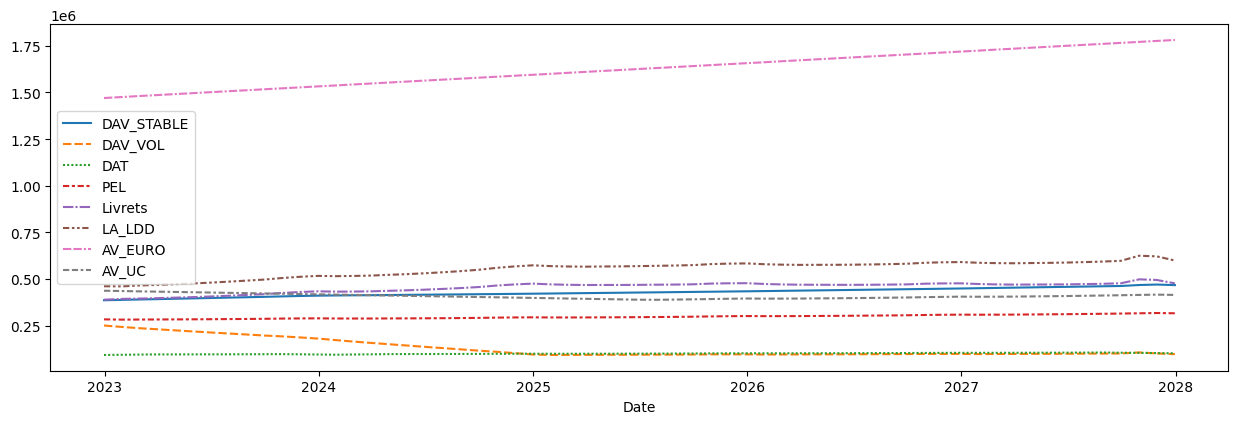

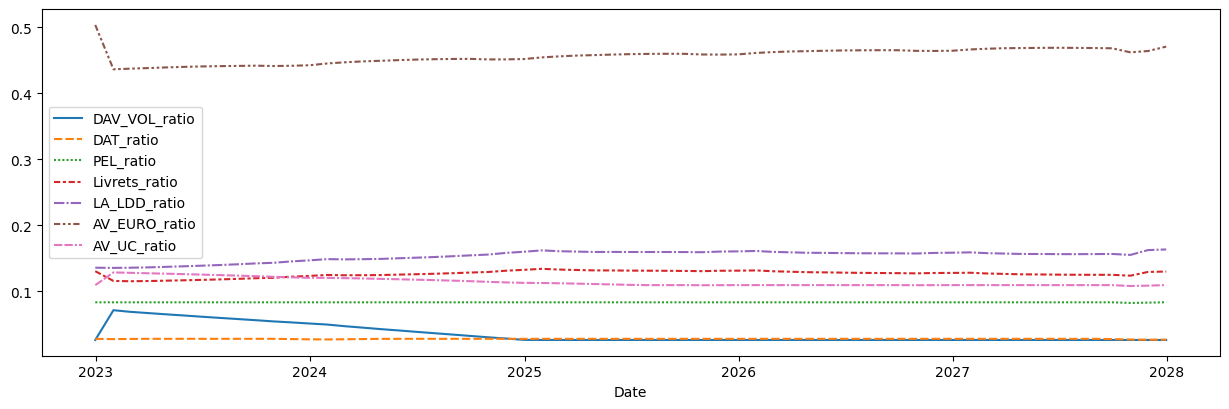

In [1192]:
''' Ménages - Capitalisation et arbitrage des encours '''

target_to_drivers = {
    "Menages_AV_Euro_Corrige": ["Euribor_3M_6MROLLING", "OAT_10Y_3YROLLING"],
    "Menages_AV_UC": ["Epargne_menages_ratio_6MROLLING", "CAC40_6MROLLING"],
    "Menages_DAT": ["Epargne_menages_ratio_6MROLLING"],
    "Menages_DAV_Vol": ['Euribor_3M_6MROLLING'], 
    "Menages_LA_LDD": ["LA_rate", 'Inflation'],
    "Menages_Livrets": ["Inflation", "LA_rate"],
    "Menages_PEL": ["Epargne_menages_ratio_6MROLLING", "LA_rate_6MROLLING"]
}

renaming = {
    "Menages_AV_Euro_Corrige": 'AV_EURO',
    "Menages_AV_UC": 'AV_UC',
    "Menages_DAT": 'DAT',
    "Menages_DAV_Stable": 'DAV_STABLE',
    "Menages_DAV_Vol": 'DAV_VOL',
    "Menages_LA_LDD": 'LA_LDD',
    "Menages_Livrets": 'Livrets',
    "Menages_PEL": 'PEL'
}

renaming_reversed = {v: k for k, v in renaming.items()}

products_arbitrable = {
    'DAV_STABLE': False,
    'DAV_VOL': True,
    'DAT': True,
    'PEL': True,
    'Livrets': True,
    'LA_LDD': True,
    'Autres': False,
    'AV_EURO': True,
    'AV_UC': True
}

df_projection['DAV_VOL_taux'] = 0
df_projection['DAV_STABLE_taux'] = 0
df_projection['DAT_taux'] = 0.000541666666666667 * 12
df_projection['PEL_taux'] = 0.0259916666666667
df_projection['Livrets_taux'] = 0.000075 * (df_projection['LA_rate']/(df_projection['LA_rate'].shift(1).fillna(1))).cumprod() * 12
df_projection['LA_LDD_taux'] = df_projection['LA_rate'] / 100
df_projection['Autres_taux'] = df_projection['Livrets_taux']
coeffs = (0.0104499019918081, 0.591229809892125)
df_projection['AV_EURO_taux'] = (coeffs[0] + coeffs[1] * df_projection['OAT_10Y_L5Y'] / 100)
coeffs = (0., 0.8)
df_projection['AV_UC_taux'] = (coeffs[0] + coeffs[1] * df_projection['CAC40_Diff'] / df_projection['CAC40'].shift(1))


# Scenarios (initial at 2022-12)
df_bdf_quarterly = df_bdf_quarterly[df_bdf_quarterly['Date'] <= projection_start_date]
df_bdf_quarterly = df_bdf_quarterly.sort_values('Date', ascending=True)
df_bdf_monthly = df_bdf_monthly[df_bdf_monthly['Date'] <= projection_start_date]
df_bdf_monthly = df_bdf_monthly.sort_values('Date', ascending=True)

products_initial_balance = {
    'DAV_STABLE': df_projection['dav_part_stable'].values[0],
    'DAV_VOL': df_bdf_monthly['Dépôts à vue des ménages et ISBLSM résidents, encours'].values[-1] - df_projection['dav_part_stable'].values[0],
    'DAT':  df_bdf_monthly['Dépôts à terme des ménages et ISBLSM résidents, encours'].values[-1] - df_bdf_monthly['PEL des ménages résidents, encours'].values[-1],
    'PEL':  df_bdf_monthly['PEL des ménages résidents, encours'].values[-1],
    'Livrets':  df_bdf_monthly["Livrets d'épargne des ménages et ISBLSM résidents, encours"].values[-1] - (df_bdf_monthly["Livrets A des ménages et ISBLSM résidents, encours"].values[-1] + df_bdf_monthly["Livrets de développement durable et solidaire des ménages résidents, encours"].values[-1]), 
    'LA_LDD':  df_bdf_monthly["Livrets A des ménages et ISBLSM résidents, encours"].values[-1] + df_bdf_monthly["Livrets de développement durable et solidaire des ménages résidents, encours"].values[-1],
    'Autres':  (df_bdf_quarterly['Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - encours de monnaie et dépôts'].values[-1]) / (3 * 1e3) - (df_bdf_monthly['Dépôts à vue des ménages et ISBLSM résidents, encours'].values[-1] + df_bdf_monthly['Dépôts à terme des ménages et ISBLSM résidents, encours'].values[-1] + df_bdf_monthly["Livrets d'épargne des ménages et ISBLSM résidents, encours"].values[-1]),
    'AV_EURO':  df_bdf_quarterly['Assurance-vie support euro, actif des ménages, encours trimestriel'].values[-1],
    'AV_UC': df_bdf_quarterly['Assurance-vie en unités de compte, actif des ménages, encours trimestriel'].values[-1]
}

products_interests_frequency = {
    'DAV_STABLE': 1,
    'DAV_VOL':  1,
    'DAT': 12,
    'PEL': 12,
    'Livrets': 12, 
    'LA_LDD': 12,
    'Autres': 12,
    'AV_EURO': 12,
    'AV_UC': 12,
}

products_liquidity = load(f'models/products_liquidity.joblib')
# for (p, v) in products_arbitrable.items():
#     quantile = 0.75
#     if v:
#         sub_df = np.abs(df_train[renaming_reversed[p]] - df_train[renaming_reversed[p]].shift(1))
#         sub_df = sub_df[sub_df > 1e-6]
#         products_liquidity[p] = sub_df.quantile(quantile)

products_is_liquid = {
    'DAV_STABLE': True,
    'DAV_VOL':  True,
    'DAT': False,
    'PEL': False,
    'Livrets': True, 
    'LA_LDD': True,
    'Autres': False,
    'AV_EURO': False,
    'AV_UC': False,
}


# '''Ratio & Feature engineering'''


# df_projection['LA_rate'] = df_projection['LA_LDD_taux']*100
# df_projection['LA_minus_OAT'] = df['LA_rate'] - df['OAT_10Y'].rolling(window=5, min_periods=1).mean()
# df_projection['OAT_10Y_3YROLLING'] = df['OAT_10Y'].rolling(window=12*3, min_periods=1).mean()
# df_projection['Epargne_menages_ratio'] = df_projection['Epargne_menages'] / df_projection['RDB']
# df_projection['Consommation_menages_courant_ratio'] = df_projection['Consommation_menages_courant'] / df_projection['RDB']

for (k,v) in target_to_drivers.items():
    for driver in v:
        if "_6MROLLING" in driver:
            df_projection[driver] = df_projection['_'.join(driver.split('_')[:-1])].rolling(6, min_periods=1).mean()

for (k,v) in target_to_drivers.items():
    df_projection[f"{renaming[k]}_ratio"] = models[k].predict(df_projection[target_to_drivers[k]])
    df_projection[f"{renaming[k]}_ratio"] = df_projection[f"{renaming[k]}_ratio"].apply(lambda x: max(x,0))


def projection_non_arbitrable(df, i, p):
    if p == 'Autres':
        return df.loc[i - 1, p] 
    elif p == 'DAV_STABLE':
        return df.loc[i, "dav_part_stable"]


def generate_interests(df, i, p, frequency):
    return 0. # Interests are already included in households revenue
    # depth = max(i, frequency)
    # # generate interests
    # if df.loc[i, "Date"].month % frequency == 0:
    #     return (df.loc[i - frequency + 1: i, p] * df.loc[i - frequency + 1: i, f"{p}_taux"]).sum() / 12
    # return 0

Encours_arbitrable = sum([products_initial_balance[k] for k in products_initial_balance.keys() if products_arbitrable[k]])
df_projection['Encours_arbitrable'] = 0.
interests = 0.
for p in products_arbitrable.keys():
    df_projection[p] = 0.
for p in products_interests_frequency.keys():
    df_projection[f"{p}_interests"] = 0.

df_projection.reset_index(inplace=True, drop=True)
for i, row in df_projection.iterrows():
    if i == 0:
        df_projection.loc[i, 'Encours_arbitrable'] = Encours_arbitrable
        for p in products_arbitrable.keys():
            df_projection.loc[i, p] = products_initial_balance[p]      
    else:
        df_projection.loc[i, 'Encours_arbitrable'] = df_projection.loc[i - 1, 'Encours_arbitrable'] + df_projection.loc[i, 'flux_a_epargner'] + interests
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                df_projection.loc[i, p] = df_projection.loc[i, f"{p}_ratio"] * df_projection.loc[i, 'Encours_arbitrable']
            else:
                df_projection.loc[i, p] = projection_non_arbitrable(df_projection, i, p)
        # Applying repartition effects
        standardization_factor_liquid = 0
        standardization_factor_non_liquid = 0
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                current_val = df_projection.loc[i - 1, p]
                target_val = df_projection.loc[i, p]
                liquidity = products_liquidity[p]
                new_val = current_val + np.sign(target_val - current_val) * min(liquidity, np.abs(target_val - current_val))
                df_projection.loc[i, f"{p}_ratio"] = new_val / df_projection.loc[i, 'Encours_arbitrable']
                standardization_factor_liquid += products_is_liquid[p] * new_val / df_projection.loc[i, 'Encours_arbitrable']
                standardization_factor_non_liquid += (1 - products_is_liquid[p]) * new_val / df_projection.loc[i, 'Encours_arbitrable']
        encours_restant = df_projection.loc[i, 'Encours_arbitrable']
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                if not products_is_liquid[p]:
                    df_projection.loc[i, p] = df_projection.loc[i, f"{p}_ratio"] * df_projection.loc[i, 'Encours_arbitrable']
                    encours_restant -= df_projection.loc[i, p]
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                if products_is_liquid[p]:
                    df_projection.loc[i, p] = df_projection.loc[i, f"{p}_ratio"] * encours_restant / standardization_factor_liquid
        # Generating interests
        interests = 0.
        for p in products_interests_frequency.keys():
            df_projection.loc[i, f"{p}_interests"] = generate_interests(df_projection, i, p, products_interests_frequency[p])
            interests += generate_interests(df_projection, i, p, products_interests_frequency[p])

df_projection['DAV'] = df_projection['DAV_STABLE'] + df_projection['DAV_VOL']


df_plot = df_projection.copy()
fig, ax =plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_plot.set_index("Date")[[k for k in products_initial_balance.keys() if k!='Autres']], ax=ax)
fig.show()

df_plot = df_projection.copy()
fig, ax =plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
L = [f"{k}_ratio" for k in products_arbitrable.keys() if products_arbitrable[k]]
L = [p for p in L if p != 'Autres_ratio']
figure = sns.lineplot(data=df_plot.set_index("Date")[L], ax=ax)
fig.show()

""" Export des résultats vers Excel """

df_projection[[
    'Date',
    'DAV',
    'DAT',
    'PEL',
    'Livrets',
    'LA_LDD',
    'AV_UC',
    'AV_EURO',
    'credit_immo',
    'credit_conso'
]].to_excel("outputs/projection_menages.xlsx", index=False)

In [1241]:
''' SNF - Capitalisation et arbitrage des encours '''

df_projection['reference_rate_growth'] = model_SNF_rate.predict(df_projection[['Euribor_3M']])
df_projection['reference_rate_growth'] = (df_projection["reference_rate_growth"] / df_projection["reference_rate_growth"].shift(1)).fillna(1)
df_projection['reference_rate_growth'] = df_projection['reference_rate_growth'].cumprod()
df_snf_rates = df_bdf_monthly[['Date', "Titres d'OPC monétaires, taux de valorisation de l'encours", "Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"]]
df_projection["Titres d'OPC monétaires, taux de valorisation de l'encours"] = df_snf_rates["Titres d'OPC monétaires, taux de valorisation de l'encours"].values[-1] * df_projection['reference_rate_growth']
df_projection["Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"] = df_snf_rates["Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"].values[-1] * df_projection['reference_rate_growth']

arbitrage_drivers = ["Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans", "Titres d'OPC monétaires, taux de valorisation de l'encours"]

old_drivers = df_bdf_monthly[df_bdf_monthly['Date'] < projection_start_date]
# old_drivers = old_drivers[['Date'] + arbitrage_drivers]
new_drivers = df_projection[['Date', 'dav_part_stable_SNF'] + arbitrage_drivers]
new_drivers = new_drivers.merge(df_bdf_monthly[df_bdf_monthly['Date'] == projection_start_date], on='Date', how='left')
df_arbitrage_snf = pd.concat([old_drivers, new_drivers], axis=0, ignore_index=True)
# df_arbitrage_snf = df_arbitrage_snf.merge(df_dav_SNF_histo[['Date', 'dav_part_stable_SNF_histo']])

df_arbitrage_snf["alpha_SNF_DAV_Vol"] = models_SNF['SNF_DAV_Vol'].predict(df_arbitrage_snf[arbitrage_drivers].fillna(0))
df_arbitrage_snf["alpha_SNF_DAT"] = models_SNF['SNF_DAT'].predict(df_arbitrage_snf[arbitrage_drivers].fillna(0))
df_arbitrage_snf["alpha_SNF_OPC"] = models_SNF['SNF_OPC'].predict(df_arbitrage_snf[arbitrage_drivers].fillna(0))
df_arbitrage_snf["alpha_SNF_DAV_Vol"] = df_arbitrage_snf["alpha_SNF_DAV_Vol"].apply(np.exp)
df_arbitrage_snf["alpha_SNF_DAT"] = df_arbitrage_snf["alpha_SNF_DAT"].apply(np.exp)
df_arbitrage_snf["alpha_SNF_OPC"] = df_arbitrage_snf["alpha_SNF_OPC"].apply(np.exp)
predict_sum = df_arbitrage_snf[['alpha_SNF_DAV_Vol', 'alpha_SNF_DAT', 'alpha_SNF_OPC']].sum(axis=1)
df_arbitrage_snf["alpha_SNF_DAV_Vol"] = df_arbitrage_snf["alpha_SNF_DAV_Vol"] / predict_sum
df_arbitrage_snf["alpha_SNF_DAT"] = df_arbitrage_snf["alpha_SNF_DAT"]  / predict_sum
df_arbitrage_snf["alpha_SNF_OPC"] = df_arbitrage_snf["alpha_SNF_OPC"] / predict_sum

df_arbitrage_snf = df_arbitrage_snf.merge(df_dav_SNF_histo[['Date', 'dav_part_stable_SNF_histo']], on='Date', how='left').merge(df_bdf_quarterly, on='Date', how='left')
df_arbitrage_snf['dav_part_stable_SNF'] = df_arbitrage_snf['dav_part_stable_SNF'].fillna(df_arbitrage_snf['dav_part_stable_SNF_histo'])
df_arbitrage_snf['SNF_DAV_Vol'] = df_arbitrage_snf['Dépôts à vue des SNF résidentes, encours'] - df_arbitrage_snf['dav_part_stable_SNF']
df_arbitrage_snf['SNF_DAT'] = df_arbitrage_snf["Dépôts à terme des SNF résidentes, encours"]
df_arbitrage_snf['SNF_OPC'] = df_arbitrage_snf["Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"].bfill() / 1e3

total_sum = df_arbitrage_snf[['SNF_DAV_Vol', 'SNF_DAT', 'SNF_OPC']].sum(axis=1)
df_arbitrage_snf["alpha_SNF_DAV_Vol_histo"] = (df_arbitrage_snf["SNF_DAV_Vol"] / total_sum)
df_arbitrage_snf["alpha_SNF_DAT_histo"] = (df_arbitrage_snf["SNF_DAT"] / total_sum)
df_arbitrage_snf["alpha_SNF_OPC_histo"] = (df_arbitrage_snf["SNF_OPC"] / total_sum)


is_na = df_arbitrage_snf["alpha_SNF_DAV_Vol_histo"].isnull() | df_arbitrage_snf["alpha_SNF_DAT_histo"].isnull() | df_arbitrage_snf["alpha_SNF_OPC_histo"].isnull()
df_arbitrage_snf["alpha_SNF_DAV_Vol"] = (~is_na * df_arbitrage_snf["alpha_SNF_DAV_Vol_histo"]).fillna(0) + (is_na * df_arbitrage_snf["alpha_SNF_DAV_Vol"]).fillna(0)
df_arbitrage_snf["alpha_SNF_DAT"] = (~is_na * df_arbitrage_snf["alpha_SNF_DAT_histo"]).fillna(0) + (is_na * df_arbitrage_snf["alpha_SNF_DAT"]).fillna(0)
df_arbitrage_snf["alpha_SNF_OPC"] = (~is_na * df_arbitrage_snf["alpha_SNF_OPC_histo"]).fillna(0) + (is_na * df_arbitrage_snf["alpha_SNF_OPC"]).fillna(0)

df_arbitrage_snf["alpha_SNF_DAV_Vol"] = df_arbitrage_snf["alpha_SNF_DAV_Vol"].rolling(12, min_periods=1).mean()
df_arbitrage_snf["alpha_SNF_DAT"] = df_arbitrage_snf["alpha_SNF_DAT"].rolling(12, min_periods=1).mean()
df_arbitrage_snf["alpha_SNF_OPC"] = df_arbitrage_snf["alpha_SNF_OPC"].rolling(12, min_periods=1).mean()
predict_sum = df_arbitrage_snf[['alpha_SNF_DAV_Vol', 'alpha_SNF_DAT', 'alpha_SNF_OPC']].sum(axis=1)
df_arbitrage_snf["alpha_SNF_DAV_Vol"] = (df_arbitrage_snf["alpha_SNF_DAV_Vol"] / predict_sum)
df_arbitrage_snf["alpha_SNF_DAT"] = (df_arbitrage_snf["alpha_SNF_DAT"] / predict_sum)
df_arbitrage_snf["alpha_SNF_OPC"] = (df_arbitrage_snf["alpha_SNF_OPC"] / predict_sum)
df_arbitrage_snf = df_arbitrage_snf[['Date', 'alpha_SNF_DAV_Vol', 'alpha_SNF_DAT', 'alpha_SNF_OPC']]

df_projection = df_projection.merge(df_arbitrage_snf, on='Date', how='left')

products_initial_balance = {
    'SNF_DAV_STABLE': df_projection['dav_part_stable_SNF'].values[0],
    'SNF_DAV_Vol': df_bdf_monthly['Dépôts à vue des SNF résidentes, encours'].values[-1] - df_projection['dav_part_stable_SNF'].values[0],
    'SNF_DAT':  df_bdf_monthly["Dépôts à terme des SNF résidentes, encours"].values[-1],
    'SNF_OPC':  df_bdf_quarterly["Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"].values[-1] / 1e3
}

Encours_arbitrable_SNF = products_initial_balance['SNF_DAV_Vol'] + products_initial_balance['SNF_DAT'] + products_initial_balance['SNF_OPC']
Encours_arbitrable_SNF = Encours_arbitrable_SNF + df_projection['SNF_flux_a_epargner'].fillna(0).cumsum() - df_projection['dav_part_stable_SNF'].diff().fillna(0).cumsum()
df_projection['Encours_arbitrable_SNF'] = Encours_arbitrable_SNF.apply(lambda x: max(x, 0))

df_projection['SNF_DAV_Vol'] = df_projection['Encours_arbitrable_SNF'] * df_projection['alpha_SNF_DAV_Vol']
df_projection['SNF_DAT'] = df_projection['Encours_arbitrable_SNF'] * df_projection['alpha_SNF_DAT']
df_projection['SNF_OPC'] = df_projection['Encours_arbitrable_SNF'] * df_projection['alpha_SNF_OPC']

# df_projection['SNF_DAV_Vol'] = products_initial_balance['SNF_DAV_Vol'] * (df_projection['SNF_DAV_Vol'] / df_projection['SNF_DAV_Vol'].shift(1)).fillna(1).cumprod()
# df_projection['SNF_DAT'] = products_initial_balance['SNF_DAT'] * (df_projection['SNF_DAT'] / df_projection['SNF_DAT'].shift(1)).fillna(1).cumprod()
# df_projection['SNF_OPC'] = products_initial_balance['SNF_OPC'] * (df_projection['SNF_OPC'] / df_projection['SNF_OPC'].shift(1)).fillna(1).cumprod()

df_projection['SNF_DAV'] = df_projection['SNF_DAV_Vol'] + df_projection['dav_part_stable_SNF']
df_projection = df_projection.reset_index(drop=True)
df_projection.loc[0, 'SNF_DAV'] = products_initial_balance['SNF_DAV_Vol'] + products_initial_balance['SNF_DAV_STABLE']
df_projection.loc[0, 'SNF_DAT'] = products_initial_balance['SNF_DAT']
df_projection.loc[0, 'SNF_OPC'] = products_initial_balance['SNF_OPC']


df_projection[[
    'Date',
    'SNF_DAV',
    'SNF_DAT',
    'SNF_OPC',
    'credit_invest',
    'credit_treso',
]].to_excel("outputs/projection_SNF.xlsx", index=False)

c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [1230]:
df_bdf_monthly['Dépôts à vue des SNF résidentes, encours'].values[-1] - df_projection['dav_part_stable_SNF'].values[0]

295476.6718358

In [1229]:
df_projection['dav_part_stable_SNF'].values[0]

348095.3281642

In [1223]:
df_projection.loc[0, 'SNF_DAV'] = products_initial_balance['SNF_DAV_Vol'] + products_initial_balance['SNF_DAV_STABLE']
df_projection.loc[0, 'SNF_DAT'] = products_initial_balance['SNF_DAT']
df_projection.loc[0, 'SNF_OPC'] = products_initial_balance['SNF_OPC']

In [1225]:
df_projection['SNF_DAV']

0     643572.000000
1     654132.917326
2     625747.945741
3     604614.578190
4     580156.728052
          ...      
56    388336.881421
57    390346.336391
58    389972.458621
59    390622.356113
60    399295.669676
Name: SNF_DAV, Length: 61, dtype: float64

In [1228]:
338662.211099 +  348095.328164

686757.539263

In [1227]:
df_projection['SNF_DAV_Vol']

0     338662.211099
1     313105.417638
2     286702.458401
3     260708.901508
4     235036.622475
          ...      
56         0.000000
57         0.000000
58         0.000000
59         0.000000
60         0.000000
Name: SNF_DAV_Vol, Length: 61, dtype: float64

In [1226]:
df_projection['dav_part_stable_SNF']

0     348095.328164
1     341027.499688
2     339045.487340
3     343905.676682
4     345120.105578
          ...      
56    388336.881421
57    390346.336391
58    389972.458621
59    390622.356113
60    399295.669676
Name: dav_part_stable_SNF, Length: 61, dtype: float64

In [1221]:
313105.417638 + 341027.499688

654132.917326

In [1222]:
348095.328164 + 338662.211099

686757.539263

In [1217]:
df_projection['dav_part_stable_SNF']

0     348095.328164
1     341027.499688
2     339045.487340
3     343905.676682
4     345120.105578
          ...      
56    388336.881421
57    390346.336391
58    389972.458621
59    390622.356113
60    399295.669676
Name: dav_part_stable_SNF, Length: 61, dtype: float64

In [1216]:
df_bdf_monthly['Dépôts à vue des SNF résidentes, encours']

365         NaN
366         NaN
367         NaN
368         NaN
369         NaN
         ...   
353    676251.0
354    655305.0
355    642815.0
356    637836.0
357    643572.0
Name: Dépôts à vue des SNF résidentes, encours, Length: 516, dtype: float64

In [1210]:
products_initial_balance

{'SNF_DAV_STABLE': 348095.3281642,
 'SNF_DAV_Vol': 295476.6718358,
 'SNF_DAT': 188956.0,
 'SNF_OPC': 67318.0}

In [1213]:
348095 + 295476

643571

In [1208]:
df_projection['dav_part_stable_SNF'].diff()

0             NaN
1    -7067.828476
2    -1982.012349
3     4860.189343
4     1214.428895
         ...     
56   -1360.114148
57    2009.454970
58    -373.877770
59     649.897492
60    8673.313563
Name: dav_part_stable_SNF, Length: 61, dtype: float64

In [1123]:
df_arbitrage_snf

,Date,"Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans","Titres d'OPC monétaires, taux de valorisation de l'encours"
0,1980-01-31,NaN,NaN
1,1980-02-29,NaN,NaN
2,1980-03-31,NaN,NaN
3,1980-04-30,NaN,NaN
4,1980-05-31,NaN,NaN
...,...,...,...
571,2027-08-31,0.026427,0.000398
572,2027-09-30,0.026427,0.000398
573,2027-10-31,0.026427,0.000398
574,2027-11-30,0.026427,0.000398


In [ ]:
TO DO : fix moyenne mobile avec passé réel SNF + part stable DAV SNF

In [1007]:
-10000*12*4

-480000

In [1006]:
df_projection['SNF_flux_a_epargner'].fillna(0).cumsum().head(20)

0          0.000000
1     -13190.860552
2     -23592.494929
3     -27599.971423
4     -35684.188646
5     -46765.843352
6     -56905.348322
7     -61372.915060
8     -73113.167638
9     -83162.251057
10    -93524.558369
11   -104613.181379
12   -114942.539510
13   -125460.016338
14   -139501.708264
15   -152780.437115
16   -160330.110740
17   -173368.903694
18   -185808.014911
19   -192174.364566
Name: SNF_flux_a_epargner, dtype: float64

In [1005]:
488258.397894 -8.758880e+05

-387629.602106

In [1001]:
Encours_arbitrable_SNF

0     520967.363953
1     514844.331877
2     506424.709848
3     497557.044012
4     488258.397894
          ...      
56   -395162.219056
57   -440620.255167
58   -483441.298769
59   -527526.854728
60   -579642.309869
Length: 61, dtype: float64

In [1000]:
df_projection['SNF_DAV_Vol'].tail(20)

41    0.158519
42    0.101083
43    0.072630
44    0.028286
45    0.000000
46    0.000000
47    0.000000
48    0.000000
49    0.000000
50    0.000000
51    0.000000
52    0.000000
53    0.000000
54    0.000000
55    0.000000
56    0.000000
57    0.000000
58    0.000000
59    0.000000
60    0.000000
Name: SNF_DAV_Vol, dtype: float64

In [973]:
df_projection['alpha_SNF_DAT']

0     0.165190
1     0.248523
2     0.331857
3     0.415190
4     0.498523
        ...   
56    0.999998
57    0.999998
58    0.999999
59    0.999999
60    0.999999
Name: alpha_SNF_DAT, Length: 61, dtype: float64

In [972]:
Encours_arbitrable_SNF

0     520967.363953
1     514844.331877
2     506424.709848
3     497557.044012
4     488258.397894
          ...      
56   -395162.219056
57   -440620.255167
58   -483441.298769
59   -527526.854728
60   -579642.309869
Length: 61, dtype: float64

In [971]:
df_projection['alpha_SNF_DAV_Vol']

0     0.834810
1     0.751477
2     0.668143
3     0.584810
4     0.501477
        ...   
56    0.000002
57    0.000002
58    0.000001
59    0.000001
60    0.000001
Name: alpha_SNF_DAV_Vol, Length: 61, dtype: float64

In [947]:
(df_projection['SNF_DAT'] / df_projection['SNF_DAT'].shift(1)).fillna(1).cumprod()

0     1.000000
1     1.486787
2     1.952861
3     2.400466
4     2.828401
        ...   
56   -4.591774
57   -5.119996
58   -5.617577
59   -6.129851
60   -6.735432
Name: SNF_DAT, Length: 61, dtype: float64

In [970]:
df_projection['SNF_DAV_Vol']

0     434908.797348
1     386893.538570
2     338364.331195
3     290976.371963
4     244850.230274
          ...      
56        -0.714473
57        -0.706420
58        -0.676058
59        -0.648669
60        -0.649317
Name: SNF_DAV_Vol, Length: 61, dtype: float64

In [863]:
Encours_arbitrable_SNF

0     520967.363953
1     514844.331877
2     506424.709848
3     497557.044012
4     488258.397894
          ...      
56   -395162.219056
57   -440620.255167
58   -483441.298769
59   -527526.854728
60   -579642.309869
Length: 61, dtype: float64

In [862]:
df_projection['SNF_flux_a_epargner']

0              NaN
1    -13190.860552
2    -10401.634378
3     -4007.476494
4     -8084.217223
          ...     
56   -42270.930586
57   -43448.581141
58   -43194.921372
59   -43435.658467
60   -43442.141578
Name: SNF_flux_a_epargner, Length: 61, dtype: float64

In [815]:
df_projection['SNF_flux_a_epargner'].fillna(0).cumsum()

0     0.000000e+00
1    -1.104809e+07
2    -2.209340e+07
3    -3.313231e+07
4    -4.107919e+07
          ...     
56   -6.188305e+08
57   -6.299089e+08
58   -6.409870e+08
59   -6.520653e+08
60   -6.631436e+08
Name: SNF_flux_a_epargner, Length: 61, dtype: float64

In [717]:
Encours_arbitrable_SNF

0     5.209674e+05
1     1.022842e+10
2     2.045633e+10
3     3.068423e+10
4     4.115491e+10
          ...     
56    5.410459e+11
57    5.426235e+11
58    5.442011e+11
59    5.457786e+11
60    5.473562e+11
Length: 61, dtype: float64

In [715]:
products_initial_balance

{'SNF_DAV_STABLE': 302415.6251668,
 'SNF_DAV_Vol': 264693.36395325337,
 'SNF_DAT': 188956.0,
 'SNF_OPC': 67318.0}

In [713]:
67318000/1e3

67318.0

In [710]:
df_projection[['Date', 'alpha_SNF_DAV_Vol', 'alpha_SNF_DAT', 'alpha_SNF_OPC']]

,Date,alpha_SNF_DAV_Vol,alpha_SNF_DAT,alpha_SNF_OPC
0,2022-12-31,0.834810,0.165190,5.653054e-12
1,2023-01-31,0.751477,0.248523,5.677622e-12
2,2023-02-28,0.668143,0.331857,5.682777e-12
3,2023-03-31,0.584810,0.415190,5.682841e-12
4,2023-04-30,0.501477,0.498523,5.682522e-12
...,...,...,...,...
56,2027-08-31,0.000002,0.999998,9.568282e-11
57,2027-09-30,0.000002,0.999998,7.537853e-11
58,2027-10-31,0.000001,0.999999,5.507425e-11
59,2027-11-30,0.000001,0.999999,3.975353e-11


In [546]:
df_projection['Encours_PGE']

0     4064.852405
1     3968.073662
2     3870.307846
3     3777.968113
4     3671.307600
         ...     
56      70.422701
57      62.802926
58      56.007615
59      49.947561
60      44.543207
Name: Encours_PGE, Length: 61, dtype: float64

In [545]:
df_projection['Encours_PGE'].values[0]

4064.85240514523

In [543]:
Encours_arbitrable_SNF

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
56   NaN
57   NaN
58   NaN
59   NaN
60   NaN
Length: 61, dtype: float64

In [542]:
Encours_arbitrable_SNF

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
56   NaN
57   NaN
58   NaN
59   NaN
60   NaN
Length: 61, dtype: float64

In [540]:
df_projection['SNF_flux_a_epargner'].fillna(0).cumsum()

0     0.000000e+00
1     1.022790e+10
2     2.045580e+10
3     3.068370e+10
4     4.115439e+10
          ...     
56    5.410455e+11
57    5.426231e+11
58    5.442006e+11
59    5.457782e+11
60    5.473558e+11
Name: SNF_flux_a_epargner, Length: 61, dtype: float64

In [ ]:

df_projection['Encours_PGE']

In [536]:
df_projection[["Date", "alpha_SNF_DAV_Vol", "alpha_SNF_DAT", "alpha_SNF_OPC"]]

,Date,alpha_SNF_DAV_Vol,alpha_SNF_DAT,alpha_SNF_OPC
0,2022-12-31,0.159276,0.478431,0.362293
1,2023-01-31,0.159276,0.478431,0.362293
2,2023-02-28,0.159276,0.478431,0.362293
3,2023-03-31,0.159276,0.478431,0.362293
4,2023-04-30,0.159276,0.478431,0.362293
...,...,...,...,...
56,2027-08-31,0.159276,0.478431,0.362293
57,2027-09-30,0.159276,0.478431,0.362293
58,2027-10-31,0.159276,0.478431,0.362293
59,2027-11-30,0.159276,0.478431,0.362293


In [ ]:
''' SNF - Capitalisation et arbitrage des encours '''

df_projection['reference_rate_growth'] = model_SNF_rate.predict(df_projection[['Euribor_3M']])
df_projection['reference_rate_growth'] = (df_projection["reference_rate_growth"] / df_projection["reference_rate_growth"].shift(1)).fillna(1)
df_projection['reference_rate_growth'] = df_projection['reference_rate_growth'].cumprod()
df_snf_rates = df_bdf_monthly[['Date', "Titres d'OPC monétaires, taux de valorisation de l'encours", "Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"]]
df_projection["Titres d'OPC monétaires, taux de valorisation de l'encours"] = df_projection["Titres d'OPC monétaires, taux de valorisation de l'encours"].ffill() * df_projection['reference_rate_growth']
df_projection["Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"] = df_projection["Titres d'OPC monétaires, taux de valorisation de l'encours"].ffill() * df_projection['reference_rate_growth']

arbitrage_drivers = ["Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans", "Titres d'OPC monétaires, taux de valorisation de l'encours"]

old_drivers = df_bdf_monthly[df_bdf_monthly['Date'] < projection_start_date]
old_drivers = old_drivers[['Date'] + arbitrage_drivers]
new_drivers = df_projection[['Date'] + arbitrage_drivers]
df_arbitrage_snf = pd.concat([old_drivers, new_drivers], axis=0, ignore_index=True)
df_arbitrage_snf["alpha_SNF_DAV_Vol"] = models_SNF['SNF_DAV_Vol'].predict(df_arbitrage_snf[arbitrage_drivers]).apply(np.exp)
df_arbitrage_snf["alpha_SNF_DAT"] = models_SNF['SNF_DAT'].predict(df_arbitrage_snf[arbitrage_drivers]).apply(np.exp)
df_arbitrage_snf["alpha_SNF_OPC"] = models_SNF['SNF_OPC'].predict(df_arbitrage_snf[arbitrage_drivers]).apply(np.exp)
predict_sum = df_arbitrage_snf[['alpha_SNF_DAV_Vol', 'alpha_SNF_DAT', 'alpha_SNF_OPC']].sum(axis=1)
df_arbitrage_snf["alpha_SNF_DAV_Vol"] = (models_SNF['SNF_DAV_Vol'].predict(df_arbitrage_snf[arbitrage_drivers]).apply(np.exp) / sum).rolling(12, min_periods=1).mean()
df_arbitrage_snf["alpha_SNF_DAT"] = (models_SNF['SNF_DAT'].predict(df_arbitrage_snf[arbitrage_drivers]).apply(np.exp) / sum).rolling(12, min_periods=1).mean()
df_arbitrage_snf["alpha_SNF_OPC"] = (models_SNF['SNF_OPC'].predict(df_arbitrage_snf[arbitrage_drivers]).apply(np.exp) / sum).rolling(12, min_periods=1).mean()
predict_sum = df_arbitrage_snf[['alpha_SNF_DAV_Vol', 'alpha_SNF_DAT', 'alpha_SNF_OPC']].sum(axis=1)
df_arbitrage_snf["alpha_SNF_DAV_Vol"] = (models_SNF['SNF_DAV_Vol'].predict(df_arbitrage_snf[arbitrage_drivers]).apply(np.exp) / sum)
df_arbitrage_snf["alpha_SNF_DAT"] = (models_SNF['SNF_DAT'].predict(df_arbitrage_snf[arbitrage_drivers]).apply(np.exp) / sum)
df_arbitrage_snf["alpha_SNF_OPC"] = (models_SNF['SNF_OPC'].predict(df_arbitrage_snf[arbitrage_drivers]).apply(np.exp) / sum)
df_arbitrage_snf = df_arbitrage_snf[['Date', 'alpha_SNF_DAV_Vol', 'alpha_SNF_DAT', 'alpha_SNF_OPC']]

df_projection = df_projection.merge(df_arbitrage_snf, on='Date', how='left')





target_to_drivers = {
    "Menages_AV_Euro_Corrige": ["Euribor_3M_6MROLLING", "OAT_10Y_3YROLLING"],
    "Menages_AV_UC": ["Epargne_menages_ratio_6MROLLING", "CAC40_6MROLLING"],
    "Menages_DAT": ["Epargne_menages_ratio_6MROLLING"],
    "Menages_DAV_Vol": ['Euribor_3M_6MROLLING'], 
    "Menages_LA_LDD": ["LA_rate", 'Inflation'],
    "Menages_Livrets": ["Inflation", "LA_rate"],
    "Menages_PEL": ["Epargne_menages_ratio_6MROLLING", "LA_rate_6MROLLING"]
}

renaming = {
    "Menages_AV_Euro_Corrige": 'AV_EURO',
    "Menages_AV_UC": 'AV_UC',
    "Menages_DAT": 'DAT',

    "Menages_DAV_Stable": 'DAV_STABLE',
    "Menages_DAV_Vol": 'DAV_VOL',
    "Menages_LA_LDD": 'LA_LDD',
    "Menages_Livrets": 'Livrets',
    "Menages_PEL": 'PEL'
}

renaming_reversed = {v: k for k, v in renaming.items()}

products_arbitrable = {
    'DAV_STABLE': False,
    'DAV_VOL': True,
    'DAT': True,
    'PEL': True,
    'Livrets': True,
    'LA_LDD': True,
    'Autres': False,
    'AV_EURO': True,
    'AV_UC': True
}

df_projection['DAV_VOL_taux'] = 0
df_projection['DAV_STABLE_taux'] = 0
df_projection['DAT_taux'] = 0.000541666666666667 * 12
df_projection['PEL_taux'] = 0.0259916666666667
df_projection['Livrets_taux'] = 0.000075 * (df_projection['LA_rate']/(df_projection['LA_rate'].shift(1).fillna(1))).cumprod() * 12
df_projection['LA_LDD_taux'] = df_projection['LA_rate'] / 100
df_projection['Autres_taux'] = df_projection['Livrets_taux']
coeffs = (0.0104499019918081, 0.591229809892125)
df_projection['AV_EURO_taux'] = (coeffs[0] + coeffs[1] * df_projection['OAT_10Y_L5Y'] / 100)
coeffs = (0., 0.8)
df_projection['AV_UC_taux'] = (coeffs[0] + coeffs[1] * df_projection['CAC40_Diff'] / df_projection['CAC40'].shift(1))


# Scenarios (initial at 2022-12)
df_bdf_quarterly = df_bdf_quarterly[df_bdf_quarterly['Date'] <= projection_start_date]
df_bdf_quarterly = df_bdf_quarterly.sort_values('Date', ascending=True)
df_bdf_monthly = df_bdf_monthly[df_bdf_monthly['Date'] <= projection_start_date]
df_bdf_monthly = df_bdf_monthly.sort_values('Date', ascending=True)

products_initial_balance = {
    'DAV_STABLE': df_projection['dav_part_stable'].values[0],
    'DAV_VOL': df_bdf_monthly['Dépôts à vue des ménages et ISBLSM résidents, encours'].values[-1] - df_projection['dav_part_stable'].values[0],
    'DAT':  df_bdf_monthly['Dépôts à terme des ménages et ISBLSM résidents, encours'].values[-1] - df_bdf_monthly['PEL des ménages résidents, encours'].values[-1],
    'PEL':  df_bdf_monthly['PEL des ménages résidents, encours'].values[-1],
    'Livrets':  df_bdf_monthly["Livrets d'épargne des ménages et ISBLSM résidents, encours"].values[-1] - (df_bdf_monthly["Livrets A des ménages et ISBLSM résidents, encours"].values[-1] + df_bdf_monthly["Livrets de développement durable et solidaire des ménages résidents, encours"].values[-1]), 
    'LA_LDD':  df_bdf_monthly["Livrets A des ménages et ISBLSM résidents, encours"].values[-1] + df_bdf_monthly["Livrets de développement durable et solidaire des ménages résidents, encours"].values[-1],
    'Autres':  (df_bdf_quarterly['Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - encours de monnaie et dépôts'].values[-1]) / (3 * 1e3) - (df_bdf_monthly['Dépôts à vue des ménages et ISBLSM résidents, encours'].values[-1] + df_bdf_monthly['Dépôts à terme des ménages et ISBLSM résidents, encours'].values[-1] + df_bdf_monthly["Livrets d'épargne des ménages et ISBLSM résidents, encours"].values[-1]),
    'AV_EURO':  df_bdf_quarterly['Assurance-vie support euro, actif des ménages, encours trimestriel'].values[-1],
    'AV_UC': df_bdf_quarterly['Assurance-vie en unités de compte, actif des ménages, encours trimestriel'].values[-1]
}

products_interests_frequency = {
    'DAV_STABLE': 1,
    'DAV_VOL':  1,
    'DAT': 12,
    'PEL': 12,
    'Livrets': 12, 
    'LA_LDD': 12,
    'Autres': 12,
    'AV_EURO': 12,
    'AV_UC': 12,
}

products_liquidity = load(f'models/products_liquidity.joblib')
# for (p, v) in products_arbitrable.items():
#     quantile = 0.75
#     if v:
#         sub_df = np.abs(df_train[renaming_reversed[p]] - df_train[renaming_reversed[p]].shift(1))
#         sub_df = sub_df[sub_df > 1e-6]
#         products_liquidity[p] = sub_df.quantile(quantile)

products_is_liquid = {
    'DAV_STABLE': True,
    'DAV_VOL':  True,
    'DAT': False,
    'PEL': False,
    'Livrets': True, 
    'LA_LDD': True,
    'Autres': False,
    'AV_EURO': False,
    'AV_UC': False,
}


# '''Ratio & Feature engineering'''


# df_projection['LA_rate'] = df_projection['LA_LDD_taux']*100
# df_projection['LA_minus_OAT'] = df['LA_rate'] - df['OAT_10Y'].rolling(window=5, min_periods=1).mean()
# df_projection['OAT_10Y_3YROLLING'] = df['OAT_10Y'].rolling(window=12*3, min_periods=1).mean()
# df_projection['Epargne_menages_ratio'] = df_projection['Epargne_menages'] / df_projection['RDB']
# df_projection['Consommation_menages_courant_ratio'] = df_projection['Consommation_menages_courant'] / df_projection['RDB']

for (k,v) in target_to_drivers.items():
    for driver in v:
        if "_6MROLLING" in driver:
            df_projection[driver] = df_projection['_'.join(driver.split('_')[:-1])].rolling(6, min_periods=1).mean()

for (k,v) in target_to_drivers.items():
    df_projection[f"{renaming[k]}_ratio"] = models[k].predict(df_projection[target_to_drivers[k]])
    df_projection[f"{renaming[k]}_ratio"] = df_projection[f"{renaming[k]}_ratio"].apply(lambda x: max(x,0))


def projection_non_arbitrable(df, i, p):
    if p == 'Autres':
        return df.loc[i - 1, p] 
    elif p == 'DAV_STABLE':
        return df.loc[i, "dav_part_stable"]


def generate_interests(df, i, p, frequency):
    return 0. # Interests are already included in households revenue
    # depth = max(i, frequency)
    # # generate interests
    # if df.loc[i, "Date"].month % frequency == 0:
    #     return (df.loc[i - frequency + 1: i, p] * df.loc[i - frequency + 1: i, f"{p}_taux"]).sum() / 12
    # return 0

Encours_arbitrable = sum([products_initial_balance[k] for k in products_initial_balance.keys() if products_arbitrable[k]])
df_projection['Encours_arbitrable'] = 0.
interests = 0.
for p in products_arbitrable.keys():
    df_projection[p] = 0.
for p in products_interests_frequency.keys():
    df_projection[f"{p}_interests"] = 0.

df_projection.reset_index(inplace=True, drop=True)
for i, row in df_projection.iterrows():
    if i == 0:
        df_projection.loc[i, 'Encours_arbitrable'] = Encours_arbitrable
        for p in products_arbitrable.keys():
            df_projection.loc[i, p] = products_initial_balance[p]      
    else:
        df_projection.loc[i, 'Encours_arbitrable'] = df_projection.loc[i - 1, 'Encours_arbitrable'] + df_projection.loc[i, 'flux_a_epargner'] + interests
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                df_projection.loc[i, p] = df_projection.loc[i, f"{p}_ratio"] * df_projection.loc[i, 'Encours_arbitrable']
            else:
                df_projection.loc[i, p] = projection_non_arbitrable(df_projection, i, p)
        # Applying repartition effects
        standardization_factor_liquid = 0
        standardization_factor_non_liquid = 0
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                current_val = df_projection.loc[i - 1, p]
                target_val = df_projection.loc[i, p]
                liquidity = products_liquidity[p]
                new_val = current_val + np.sign(target_val - current_val) * min(liquidity, np.abs(target_val - current_val))
                df_projection.loc[i, f"{p}_ratio"] = new_val / df_projection.loc[i, 'Encours_arbitrable']
                standardization_factor_liquid += products_is_liquid[p] * new_val / df_projection.loc[i, 'Encours_arbitrable']
                standardization_factor_non_liquid += (1 - products_is_liquid[p]) * new_val / df_projection.loc[i, 'Encours_arbitrable']
        encours_restant = df_projection.loc[i, 'Encours_arbitrable']
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                if not products_is_liquid[p]:
                    df_projection.loc[i, p] = df_projection.loc[i, f"{p}_ratio"] * df_projection.loc[i, 'Encours_arbitrable']
                    encours_restant -= df_projection.loc[i, p]
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                if products_is_liquid[p]:
                    df_projection.loc[i, p] = df_projection.loc[i, f"{p}_ratio"] * encours_restant / standardization_factor_liquid
        # Generating interests
        interests = 0.
        for p in products_interests_frequency.keys():
            df_projection.loc[i, f"{p}_interests"] = generate_interests(df_projection, i, p, products_interests_frequency[p])
            interests += generate_interests(df_projection, i, p, products_interests_frequency[p])

df_projection['DAV'] = df_projection['DAV_STABLE'] + df_projection['DAV_VOL']


df_plot = df_projection.copy()
fig, ax =plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_plot.set_index("Date")[[k for k in products_initial_balance.keys() if k!='Autres']], ax=ax)
fig.show()

df_plot = df_projection.copy()
fig, ax =plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
L = [f"{k}_ratio" for k in products_arbitrable.keys() if products_arbitrable[k]]
L = [p for p in L if p != 'Autres_ratio']
figure = sns.lineplot(data=df_plot.set_index("Date")[L], ax=ax)
fig.show()

In [570]:
df_projection[['Date', 'RDB_courant']].to_excel('toto.xlsx')

In [618]:
""" Export des résultats vers Excel """

df_projection[[
    'Date',
    'DAV',
    'DAT',
    'PEL',
    'Livrets',
    'LA_LDD',
    'Autres',
    'AV_UC',
    'AV_EURO',
    'credit_immo',
    'credit_conso'
]].to_excel("projections_python_tg_method_rdb_retu.xlsx", index=False)

In [25]:
df_yoy = df_projection[[
    'Date',
    'DAV',
    'DAT',
    'PEL',
    'Livrets',
    'LA_LDD',
    'Autres',
    'AV_UC',
    'AV_EURO'
]]
df_yoy = df_yoy[df_yoy['Date'].dt.month==12]
df_yoy['encours total'] = df_yoy.sum(axis=1)
for c in df_yoy.columns:
    if c!='Date':
        df_yoy[c+'_growth'] = 100 * ((df_yoy[c] - df_yoy[c].shift(1)) / df_yoy[c].shift(1))
        df_yoy[c+'_growth'] = df_yoy[c+'_growth'].round(2).astype(str) + ' %'
display(df_yoy)
df_yoy.to_excel("YoY_python.xlsx", index=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20356\3037002416.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_yoy['encours total'] = df_yoy.sum(axis=1)


,Date,DAV,DAT,PEL,Livrets,LA_LDD,Autres,AV_UC,AV_EURO,encours total,DAV_growth,DAT_growth,PEL_growth,Livrets_growth,LA_LDD_growth,Autres_growth,AV_UC_growth,AV_EURO_growth,encours total_growth
3,2022-12-01,691536.228794,79571.0,283922.0,400418.682832,456826.650737,170111.0,373842.862496,1576367.0,4.032595e+06,nan %,nan %,nan %,nan %,nan %,nan %,nan %,nan %,nan %
15,2023-12-01,748832.825740,86147.0,289838.0,425828.090088,511992.668594,170111.0,386528.512542,1612687.0,4.231965e+06,8.29 %,8.26 %,2.08 %,6.35 %,12.08 %,0.0 %,3.39 %,2.3 %,4.94 %
27,2024-12-01,767449.264650,92723.0,295754.0,482239.076800,576646.495874,170111.0,399214.162587,1649007.0,4.433144e+06,2.49 %,7.63 %,2.04 %,13.25 %,12.63 %,0.0 %,3.28 %,2.25 %,4.75 %
39,2025-12-01,782474.741093,99299.0,301670.0,551550.499399,642060.166579,170111.0,411899.812633,1685327.0,4.644392e+06,1.96 %,7.09 %,2.0 %,14.37 %,11.34 %,0.0 %,3.18 %,2.2 %,4.77 %
51,2026-12-01,802623.771804,105875.0,307586.0,613609.889324,722632.356572,170111.0,424585.462678,1721647.0,4.868670e+06,2.58 %,6.62 %,1.96 %,11.25 %,12.55 %,0.0 %,3.08 %,2.16 %,4.83 %
63,2027-12-01,787563.563758,112451.0,313502.0,643035.102489,765320.460085,170111.0,437271.112724,1757967.0,4.987221e+06,-1.88 %,6.21 %,1.92 %,4.8 %,5.91 %,0.0 %,2.99 %,2.11 %,2.43 %


C:\Users\Admin\AppData\Local\Temp\ipykernel_20356\2199377455.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_yoy['encours total'] = df_yoy.sum(axis=1)
